In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install ninja

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install -U fastai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install keras-tcn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
os.environ['PYTHONHASHSEED']=str(1)
import random
from tensorflow import keras
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow.keras.layers import BatchNormalization,Dropout
from tensorflow.keras import models, layers, losses, optimizers, activations, regularizers
from tensorflow.keras.layers import LeakyReLU
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tcn import TCN
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice
import joblib
import pickle
from keras.engine.input_spec import InputSpec
initializer = tf.keras.initializers.Zeros()
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [ ]:
def reset_random_seeds():
   os.environ['PYTHONHASHSEED']=str(1)
   tf.random.set_seed(1)
   np.random.seed(1)
   random.seed(1)

In [ ]:
flow = np.load('/content/drive/MyDrive/CNN model data/lung_data/flow400.npy')
volume = np.load('/content/drive/MyDrive/CNN model data/lung_data/volume400.npy')
paw = np.load('/content/drive/MyDrive/CNN model data/lung_data/paw400.npy')
capacitances = np.load('/content/drive/MyDrive/CNN model data/lung_data/capacitances400.npy')
resistances = np.load("/content/drive/MyDrive/CNN model data/lung_data/rins400.npy")
#output1 = np.load("/content/drive/MyDrive/CNN model data/output1.npy")
#input1 = np.load("/content/drive/MyDrive/CNN model data/input1.npy")

In [ ]:
def normalize_data(data, minimum = None,maximum = None):
    if minimum is None:
        minimum = np.min(np.min(data))
    if maximum is None:
        maximum = np.max(np.max(data))
    data_norm = (data - minimum) / (maximum - minimum)
    return minimum, maximum, data_norm


In [ ]:
flow = flow.T
volume = volume.T
paw = paw.T
resistances = resistances.T
capacitances = capacitances.T

print("transposed")

num_examples = flow.shape[0]
num_samples = flow.shape[1]
print("num_samples are",num_examples)
(min_flow, max_flow, flow) = normalize_data(flow)
(min_volume, max_volume, volume) = normalize_data(volume)
(min_paw, max_paw, paw) = normalize_data(paw)
(min_resistance, max_resistance, resistances) = normalize_data(resistances)
(min_capacitance, max_capacitance, capacitances) = normalize_data(capacitances)

print("normalized data")

input_data = np.zeros((num_examples, num_samples, 3))
input_data[:, :, 0] = flow
input_data[:, :, 1] = volume
input_data[:, :, 2] = paw
output_data = np.concatenate((resistances, capacitances), axis=1)
indices = np.arange(num_examples)

print("input created")




transposed
num_samples are 400
normalized data
input created


In [ ]:
input_train, input_test, output_train, output_test, indices_train, indices_test = \
    train_test_split(input_data, output_data, indices, test_size=0.3, shuffle=False, random_state=11)

input_validation, input_test, output_validation, output_test, indices_validation, indices_test = \
    train_test_split(input_test, output_test, indices_test, test_size=0.5, shuffle=False, random_state=11)

In [ ]:
def objective(trial):
    reset_random_seeds()
    params = {
              'learning_rate': trial.suggest_uniform('learning_rate', 1e-5, 1e-3),
              'nb_filter': trial.suggest_categorical("nb_filter", [2, 3]),
              'kernel_size': trial.suggest_int("kernel_size",2, 3, 5),
              'nb_stacks': trial.suggest_int("nb_stacks",1,2,3),
              'decay': trial.suggest_categorical("decay",[1e-3, 1e-5]),
              'dense1': trial.suggest_int('dense1',50,100,150),
              'dense2': trial.suggest_int('dense2',50,100,150),
              #'optimizer': trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"]),
              'activation1': trial.suggest_categorical("activation1", ["relu", "LeakyReLU", "linear"]),
              'activation2': trial.suggest_categorical("activation2", ["relu", "LeakyReLU", "linear"]),
              'layers1': trial.suggest_categorical("layers1", [1,3]),
              'layers2': trial.suggest_categorical("layers2", [1,3]),
              'dropout_rate': trial.suggest_categorical("dropout_rate", [0.0,0.3]),
              'epochs': trial.suggest_categorical("epochs", [100,150])
              }
    model = Sequential()
    model.add(TCN(
      input_shape=(num_samples,3),
      nb_filters=params['nb_filter'],
      kernel_size=params['kernel_size'],
      nb_stacks=params['nb_stacks'],
      dilations=(1, 2, 4, 8),
      padding='causal',
      use_skip_connections=True,
      dropout_rate=0.05,
      return_sequences=False,
      activation='relu',
      kernel_initializer='he_normal',
      use_batch_norm=False,
      use_layer_norm=False,
      use_weight_norm=False,
      go_backwards=False,
      return_state=False,
    ))  

    #model.add(Flatten())
    for i in range(params['layers1']):
      model.add(Dense(params['dense1'], activation=params['activation1']))
    #if Dropout> 0.5:
      #model.add(Dropout(params['dropout_rate'])) 
    for i in range(params['layers2']):
      model.add(Dense(params['dense2'], activation=params['activation2']))
    model.add(Dense(2))
    model.compile(optimizer=optimizers.Adam(lr=params['learning_rate'], decay=params['decay']), loss=losses.mean_squared_error)

    history = model.fit(input_train, output_train, epochs=params['epochs'], verbose=1,
            validation_data=(input_validation, output_validation)
            )#callbacks=[es_callback]
#epochs=params['epochs']
    y_pred = model.predict(input_test)
    mse = mean_squared_error(output_test, y_pred)
    mae = mean_absolute_error(output_test,y_pred)
    mape = mean_absolute_percentage_error(output_test,y_pred)

    with open("/content/drive/MyDrive/TCN_400/{}.pickle".format(trial.number), "wb") as fout:
        pickle.dump(model, fout)
    return mse

In [ ]:
import optuna
reset_random_seeds()
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=21))
study.optimize(objective, n_trials=100)

[I 2022-11-14 14:50:45,935] A new study created in memory with name: no-name-0bef1ab3-30df-4f94-9f05-25c8910d1e6f
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.


Epoch 1/100
9/9 [==============================] - 3s 163ms/step - loss: 0.1143 - val_loss: 0.0815
Epoch 2/100
9/9 [==============================] - 1s 124ms/step - loss: 0.0967 - val_loss: 0.0729
Epoch 3/100
9/9 [==============================] - 1s 122ms/step - loss: 0.0917 - val_loss: 0.0707
Epoch 4/100
9/9 [==============================] - 1s 139ms/step - loss: 0.0909 - val_loss: 0.0694
Epoch 5/100
9/9 [==============================] - 1s 139ms/step - loss: 0.0876 - val_loss: 0.0680
Epoch 6/100
9/9 [==============================] - 1s 138ms/step - loss: 0.0863 - val_loss: 0.0670
Epoch 7/100
9/9 [==============================] - 1s 131ms/step - loss: 0.0836 - val_loss: 0.0670
Epoch 8/100
9/9 [==============================] - 1s 140ms/step - loss: 0.0871 - val_loss: 0.0669
Epoch 9/100
9/9 [==============================] - 1s 142ms/step - loss: 0.0857 - val_loss: 0.0662
Epoch 10/100
9/9 [==============================] - 1s 148ms/step - loss: 0.0823 - val_loss: 0.0656
Epoch 11/

[I 2022-11-14 14:52:49,129] Trial 0 finished with value: 0.061310371235159956 and parameters: {'learning_rate': 5.8237632001036017e-05, 'nb_filter': 3, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'linear', 'activation2': 'LeakyReLU', 'layers1': 1, 'layers2': 3, 'dropout_rate': 0.0, 'epochs': 100}. Best is trial 0 with value: 0.061310371235159956.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/d

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 134ms/step - loss: 0.0998 - val_loss: 0.0673
Epoch 2/100
9/9 [==============================] - 1s 97ms/step - loss: 0.0884 - val_loss: 0.0671
Epoch 3/100
9/9 [==============================] - 1s 92ms/step - loss: 0.0872 - val_loss: 0.0680
Epoch 4/100
9/9 [==============================] - 1s 94ms/step - loss: 0.0849 - val_loss: 0.0647
Epoch 5/100
9/9 [==============================] - 1s 94ms/step - loss: 0.0812 - val_loss: 0.0641
Epoch 6/100
9/9 [==============================] - 1s 93ms/step - loss: 0.0786 - val_loss: 0.0632
Epoch 7/100
9/9 [==============================] - 1s 98ms/step - loss: 0.0779 - val_loss: 0.0633
Epoch 8/100
9/9 [==============================] - 1s 95ms/step - loss: 0.0785 - val_loss: 0.0625
Epoch 9/100
9/9 [==============================] - 1s 93ms/step - loss: 0.0772 - val_loss: 0.0609
Epoch 10/100
9/9 [==============================] - 1s 91ms/step - loss: 0.0754 - val_loss: 0.0620
Epoch 11/100
9/9 [============

[I 2022-11-14 14:54:21,350] Trial 1 finished with value: 0.06367555398126995 and parameters: {'learning_rate': 0.00039040753176922816, 'nb_filter': 3, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'relu', 'activation2': 'LeakyReLU', 'layers1': 3, 'layers2': 1, 'dropout_rate': 0.0, 'epochs': 100}. Best is trial 0 with value: 0.061310371235159956.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 143ms/step - loss: 0.1622 - val_loss: 0.0954
Epoch 2/100
9/9 [==============================] - 1s 96ms/step - loss: 0.1158 - val_loss: 0.0781
Epoch 3/100
9/9 [==============================] - 1s 99ms/step - loss: 0.1076 - val_loss: 0.0759
Epoch 4/100
9/9 [==============================] - 1s 93ms/step - loss: 0.0972 - val_loss: 0.0717
Epoch 5/100
9/9 [==============================] - 1s 101ms/step - loss: 0.0921 - val_loss: 0.0702
Epoch 6/100
9/9 [==============================] - 1s 105ms/step - loss: 0.0845 - val_loss: 0.0675
Epoch 7/100
9/9 [==============================] - 1s 102ms/step - loss: 0.0821 - val_loss: 0.0652
Epoch 8/100
9/9 [==============================] - 1s 96ms/step - loss: 0.0784 - val_loss: 0.0633
Epoch 9/100
9/9 [==============================] - 1s 101ms/step - loss: 0.0757 - val_loss: 0.0630
Epoch 10/100
9/9 [==============================] - 1s 95ms/step - loss: 0.0721 - val_loss: 0.0618
Epoch 11/100
9/9 [========

[I 2022-11-14 14:55:54,580] Trial 2 finished with value: 0.06285439970394634 and parameters: {'learning_rate': 0.0006186764640369503, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'LeakyReLU', 'activation2': 'LeakyReLU', 'layers1': 1, 'layers2': 1, 'dropout_rate': 0.0, 'epochs': 100}. Best is trial 0 with value: 0.061310371235159956.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 134ms/step - loss: 0.1283 - val_loss: 0.0778
Epoch 2/100
9/9 [==============================] - 1s 97ms/step - loss: 0.1042 - val_loss: 0.0773
Epoch 3/100
9/9 [==============================] - 1s 95ms/step - loss: 0.0940 - val_loss: 0.0682
Epoch 4/100
9/9 [==============================] - 1s 93ms/step - loss: 0.0852 - val_loss: 0.0641
Epoch 5/100
9/9 [==============================] - 1s 95ms/step - loss: 0.0770 - val_loss: 0.0620
Epoch 6/100
9/9 [==============================] - 1s 102ms/step - loss: 0.0727 - val_loss: 0.0596
Epoch 7/100
9/9 [==============================] - 1s 94ms/step - loss: 0.0710 - val_loss: 0.0590
Epoch 8/100
9/9 [==============================] - 1s 94ms/step - loss: 0.0676 - val_loss: 0.0588
Epoch 9/100
9/9 [==============================] - 1s 97ms/step - loss: 0.0672 - val_loss: 0.0588
Epoch 10/100
9/9 [==============================] - 1s 96ms/step - loss: 0.0655 - val_loss: 0.0598
Epoch 11/100
9/9 [===========

[I 2022-11-14 14:57:28,121] Trial 3 finished with value: 0.061734803556181134 and parameters: {'learning_rate': 0.000594553185907923, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 0.001, 'dense1': 50, 'dense2': 50, 'activation1': 'linear', 'activation2': 'LeakyReLU', 'layers1': 1, 'layers2': 3, 'dropout_rate': 0.0, 'epochs': 100}. Best is trial 0 with value: 0.061310371235159956.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dis

Epoch 1/150


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 135ms/step - loss: 0.1637 - val_loss: 0.0845
Epoch 2/150
9/9 [==============================] - 1s 94ms/step - loss: 0.0941 - val_loss: 0.0745
Epoch 3/150
9/9 [==============================] - 1s 92ms/step - loss: 0.0866 - val_loss: 0.0641
Epoch 4/150
9/9 [==============================] - 1s 91ms/step - loss: 0.0834 - val_loss: 0.0617
Epoch 5/150
9/9 [==============================] - 1s 92ms/step - loss: 0.0772 - val_loss: 0.0648
Epoch 6/150
9/9 [==============================] - 1s 91ms/step - loss: 0.0765 - val_loss: 0.0616
Epoch 7/150
9/9 [==============================] - 1s 93ms/step - loss: 0.0744 - val_loss: 0.0627
Epoch 8/150
9/9 [==============================] - 1s 93ms/step - loss: 0.0758 - val_loss: 0.0615
Epoch 9/150
9/9 [==============================] - 1s 94ms/step - loss: 0.0741 - val_loss: 0.0616
Epoch 10/150
9/9 [==============================] - 1s 92ms/step - loss: 0.0715 - val_loss: 0.0604
Epoch 11/150
9/9 [============

[I 2022-11-14 14:59:41,285] Trial 4 finished with value: 0.06351078797144726 and parameters: {'learning_rate': 0.0006378214461455954, 'nb_filter': 3, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'linear', 'activation2': 'relu', 'layers1': 3, 'layers2': 1, 'dropout_rate': 0.0, 'epochs': 150}. Best is trial 0 with value: 0.061310371235159956.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist-pac

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 155ms/step - loss: 0.2582 - val_loss: 0.1874
Epoch 2/100
9/9 [==============================] - 1s 105ms/step - loss: 0.1791 - val_loss: 0.1288
Epoch 3/100
9/9 [==============================] - 1s 116ms/step - loss: 0.1358 - val_loss: 0.0975
Epoch 4/100
9/9 [==============================] - 1s 105ms/step - loss: 0.1184 - val_loss: 0.0847
Epoch 5/100
9/9 [==============================] - 1s 102ms/step - loss: 0.1185 - val_loss: 0.0809
Epoch 6/100
9/9 [==============================] - 1s 104ms/step - loss: 0.1108 - val_loss: 0.0795
Epoch 7/100
9/9 [==============================] - 1s 108ms/step - loss: 0.1103 - val_loss: 0.0799
Epoch 8/100
9/9 [==============================] - 1s 104ms/step - loss: 0.1069 - val_loss: 0.0790
Epoch 9/100
9/9 [==============================] - 1s 109ms/step - loss: 0.1041 - val_loss: 0.0778
Epoch 10/100
9/9 [==============================] - 1s 99ms/step - loss: 0.1010 - val_loss: 0.0763
Epoch 11/100
9/9 [====

[I 2022-11-14 15:01:23,020] Trial 5 finished with value: 0.06270774247215814 and parameters: {'learning_rate': 7.926972549929831e-05, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 0.001, 'dense1': 50, 'dense2': 50, 'activation1': 'LeakyReLU', 'activation2': 'linear', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.0, 'epochs': 100}. Best is trial 0 with value: 0.061310371235159956.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dis

Epoch 1/150


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 150ms/step - loss: 0.1277 - val_loss: 0.0757
Epoch 2/150
9/9 [==============================] - 1s 104ms/step - loss: 0.0971 - val_loss: 0.0724
Epoch 3/150
9/9 [==============================] - 1s 112ms/step - loss: 0.0842 - val_loss: 0.0631
Epoch 4/150
9/9 [==============================] - 1s 107ms/step - loss: 0.0763 - val_loss: 0.0614
Epoch 5/150
9/9 [==============================] - 1s 99ms/step - loss: 0.0705 - val_loss: 0.0585
Epoch 6/150
9/9 [==============================] - 1s 102ms/step - loss: 0.0677 - val_loss: 0.0582
Epoch 7/150
9/9 [==============================] - 1s 103ms/step - loss: 0.0673 - val_loss: 0.0578
Epoch 8/150
9/9 [==============================] - 1s 104ms/step - loss: 0.0652 - val_loss: 0.0581
Epoch 9/150
9/9 [==============================] - 1s 100ms/step - loss: 0.0663 - val_loss: 0.0585
Epoch 10/150
9/9 [==============================] - 1s 103ms/step - loss: 0.0655 - val_loss: 0.0591
Epoch 11/150
9/9 [====

[I 2022-11-14 15:03:51,873] Trial 6 finished with value: 0.06112011983093863 and parameters: {'learning_rate': 0.0009176058843603533, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 0.001, 'dense1': 50, 'dense2': 50, 'activation1': 'relu', 'activation2': 'LeakyReLU', 'layers1': 3, 'layers2': 1, 'dropout_rate': 0.3, 'epochs': 150}. Best is trial 6 with value: 0.06112011983093863.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist-p

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 143ms/step - loss: 0.1747 - val_loss: 0.0776
Epoch 2/100
9/9 [==============================] - 1s 105ms/step - loss: 0.1163 - val_loss: 0.0745
Epoch 3/100
9/9 [==============================] - 1s 103ms/step - loss: 0.0966 - val_loss: 0.0734
Epoch 4/100
9/9 [==============================] - 1s 103ms/step - loss: 0.0874 - val_loss: 0.0686
Epoch 5/100
9/9 [==============================] - 1s 104ms/step - loss: 0.0790 - val_loss: 0.0634
Epoch 6/100
9/9 [==============================] - 1s 103ms/step - loss: 0.0743 - val_loss: 0.0620
Epoch 7/100
9/9 [==============================] - 1s 101ms/step - loss: 0.0724 - val_loss: 0.0619
Epoch 8/100
9/9 [==============================] - 1s 104ms/step - loss: 0.0681 - val_loss: 0.0607
Epoch 9/100
9/9 [==============================] - 1s 105ms/step - loss: 0.0681 - val_loss: 0.0606
Epoch 10/100
9/9 [==============================] - 1s 102ms/step - loss: 0.0669 - val_loss: 0.0611
Epoch 11/100
9/9 [===

[I 2022-11-14 15:05:32,409] Trial 7 finished with value: 0.06217703616460952 and parameters: {'learning_rate': 0.0009258713666959175, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'LeakyReLU', 'activation2': 'linear', 'layers1': 1, 'layers2': 1, 'dropout_rate': 0.0, 'epochs': 100}. Best is trial 6 with value: 0.06112011983093863.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist

Epoch 1/150


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 140ms/step - loss: 0.1738 - val_loss: 0.1532
Epoch 2/150
9/9 [==============================] - 1s 104ms/step - loss: 0.1615 - val_loss: 0.1390
Epoch 3/150
9/9 [==============================] - 1s 110ms/step - loss: 0.1491 - val_loss: 0.1264
Epoch 4/150
9/9 [==============================] - 1s 103ms/step - loss: 0.1415 - val_loss: 0.1152
Epoch 5/150
9/9 [==============================] - 1s 102ms/step - loss: 0.1321 - val_loss: 0.1056
Epoch 6/150
9/9 [==============================] - 1s 100ms/step - loss: 0.1207 - val_loss: 0.0974
Epoch 7/150
9/9 [==============================] - 1s 100ms/step - loss: 0.1166 - val_loss: 0.0912
Epoch 8/150
9/9 [==============================] - 1s 106ms/step - loss: 0.1141 - val_loss: 0.0864
Epoch 9/150
9/9 [==============================] - 1s 105ms/step - loss: 0.1102 - val_loss: 0.0834
Epoch 10/150
9/9 [==============================] - 1s 106ms/step - loss: 0.1066 - val_loss: 0.0812
Epoch 11/150
9/9 [===

[I 2022-11-14 15:08:01,593] Trial 8 finished with value: 0.061993390933001366 and parameters: {'learning_rate': 7.206229750730598e-05, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'linear', 'activation2': 'relu', 'layers1': 1, 'layers2': 3, 'dropout_rate': 0.3, 'epochs': 150}. Best is trial 6 with value: 0.06112011983093863.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist-pac

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 140ms/step - loss: 0.2142 - val_loss: 0.1019
Epoch 2/100
9/9 [==============================] - 1s 100ms/step - loss: 0.1203 - val_loss: 0.0753
Epoch 3/100
9/9 [==============================] - 1s 92ms/step - loss: 0.0985 - val_loss: 0.0774
Epoch 4/100
9/9 [==============================] - 1s 98ms/step - loss: 0.0891 - val_loss: 0.0687
Epoch 5/100
9/9 [==============================] - 1s 98ms/step - loss: 0.0819 - val_loss: 0.0643
Epoch 6/100
9/9 [==============================] - 1s 95ms/step - loss: 0.0750 - val_loss: 0.0632
Epoch 7/100
9/9 [==============================] - 1s 99ms/step - loss: 0.0733 - val_loss: 0.0626
Epoch 8/100
9/9 [==============================] - 1s 98ms/step - loss: 0.0692 - val_loss: 0.0606
Epoch 9/100
9/9 [==============================] - 1s 93ms/step - loss: 0.0694 - val_loss: 0.0600
Epoch 10/100
9/9 [==============================] - 1s 97ms/step - loss: 0.0665 - val_loss: 0.0601
Epoch 11/100
9/9 [===========

[I 2022-11-14 15:09:36,005] Trial 9 finished with value: 0.062351122734517345 and parameters: {'learning_rate': 0.0008143313682980463, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 0.001, 'dense1': 50, 'dense2': 50, 'activation1': 'LeakyReLU', 'activation2': 'LeakyReLU', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.3, 'epochs': 100}. Best is trial 6 with value: 0.06112011983093863.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/

Epoch 1/150


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 156ms/step - loss: 0.1239 - val_loss: 0.0764
Epoch 2/150
9/9 [==============================] - 1s 121ms/step - loss: 0.0886 - val_loss: 0.0676
Epoch 3/150
9/9 [==============================] - 1s 117ms/step - loss: 0.0904 - val_loss: 0.0667
Epoch 4/150
9/9 [==============================] - 1s 125ms/step - loss: 0.0859 - val_loss: 0.0662
Epoch 5/150
9/9 [==============================] - 1s 126ms/step - loss: 0.0824 - val_loss: 0.0648
Epoch 6/150
9/9 [==============================] - 1s 127ms/step - loss: 0.0795 - val_loss: 0.0637
Epoch 7/150
9/9 [==============================] - 1s 120ms/step - loss: 0.0781 - val_loss: 0.0636
Epoch 8/150
9/9 [==============================] - 1s 120ms/step - loss: 0.0796 - val_loss: 0.0635
Epoch 9/150
9/9 [==============================] - 1s 111ms/step - loss: 0.0792 - val_loss: 0.0617
Epoch 10/150
9/9 [==============================] - 1s 113ms/step - loss: 0.0765 - val_loss: 0.0623
Epoch 11/150
9/9 [===

[I 2022-11-14 15:12:25,599] Trial 10 finished with value: 0.06342583965605045 and parameters: {'learning_rate': 0.0003972346538015031, 'nb_filter': 3, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 0.001, 'dense1': 50, 'dense2': 50, 'activation1': 'relu', 'activation2': 'relu', 'layers1': 3, 'layers2': 1, 'dropout_rate': 0.3, 'epochs': 150}. Best is trial 6 with value: 0.06112011983093863.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist-packa

Epoch 1/150


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 4s 178ms/step - loss: 0.1054 - val_loss: 0.0714
Epoch 2/150
9/9 [==============================] - 1s 134ms/step - loss: 0.0902 - val_loss: 0.0678
Epoch 3/150
9/9 [==============================] - 1s 133ms/step - loss: 0.0915 - val_loss: 0.0686
Epoch 4/150
9/9 [==============================] - 1s 134ms/step - loss: 0.0877 - val_loss: 0.0676
Epoch 5/150
9/9 [==============================] - 1s 133ms/step - loss: 0.0837 - val_loss: 0.0651
Epoch 6/150
9/9 [==============================] - 1s 130ms/step - loss: 0.0807 - val_loss: 0.0645
Epoch 7/150
9/9 [==============================] - 1s 128ms/step - loss: 0.0799 - val_loss: 0.0647
Epoch 8/150
9/9 [==============================] - 1s 129ms/step - loss: 0.0808 - val_loss: 0.0641
Epoch 9/150
9/9 [==============================] - 1s 130ms/step - loss: 0.0800 - val_loss: 0.0624
Epoch 10/150
9/9 [==============================] - 1s 145ms/step - loss: 0.0772 - val_loss: 0.0626
Epoch 11/150
9/9 [===

[I 2022-11-14 15:15:29,143] Trial 11 finished with value: 0.06203197164850083 and parameters: {'learning_rate': 0.00025584799798269975, 'nb_filter': 3, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 0.001, 'dense1': 50, 'dense2': 50, 'activation1': 'relu', 'activation2': 'LeakyReLU', 'layers1': 1, 'layers2': 3, 'dropout_rate': 0.3, 'epochs': 150}. Best is trial 6 with value: 0.06112011983093863.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist

Epoch 1/150


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 189ms/step - loss: 0.1382 - val_loss: 0.0650
Epoch 2/150
9/9 [==============================] - 1s 126ms/step - loss: 0.0899 - val_loss: 0.0677
Epoch 3/150
9/9 [==============================] - 1s 133ms/step - loss: 0.0825 - val_loss: 0.0641
Epoch 4/150
9/9 [==============================] - 1s 133ms/step - loss: 0.0829 - val_loss: 0.0641
Epoch 5/150
9/9 [==============================] - 1s 145ms/step - loss: 0.0778 - val_loss: 0.0659
Epoch 6/150
9/9 [==============================] - 1s 135ms/step - loss: 0.0748 - val_loss: 0.0608
Epoch 7/150
9/9 [==============================] - 1s 132ms/step - loss: 0.0722 - val_loss: 0.0612
Epoch 8/150
9/9 [==============================] - 1s 131ms/step - loss: 0.0734 - val_loss: 0.0605
Epoch 9/150
9/9 [==============================] - 1s 135ms/step - loss: 0.0712 - val_loss: 0.0611
Epoch 10/150
9/9 [==============================] - 1s 139ms/step - loss: 0.0690 - val_loss: 0.0602
Epoch 11/150
9/9 [===

[I 2022-11-14 15:18:54,061] Trial 12 finished with value: 0.06312248363439851 and parameters: {'learning_rate': 0.000786149085625244, 'nb_filter': 3, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 0.001, 'dense1': 50, 'dense2': 50, 'activation1': 'linear', 'activation2': 'LeakyReLU', 'layers1': 3, 'layers2': 1, 'dropout_rate': 0.3, 'epochs': 150}. Best is trial 6 with value: 0.06112011983093863.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist

Epoch 1/150


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 169ms/step - loss: 0.0999 - val_loss: 0.0664
Epoch 2/150
9/9 [==============================] - 1s 128ms/step - loss: 0.0831 - val_loss: 0.0661
Epoch 3/150
9/9 [==============================] - 1s 132ms/step - loss: 0.0805 - val_loss: 0.0619
Epoch 4/150
9/9 [==============================] - 1s 133ms/step - loss: 0.0796 - val_loss: 0.0622
Epoch 5/150
9/9 [==============================] - 1s 133ms/step - loss: 0.0764 - val_loss: 0.0609
Epoch 6/150
9/9 [==============================] - 1s 135ms/step - loss: 0.0743 - val_loss: 0.0625
Epoch 7/150
9/9 [==============================] - 1s 133ms/step - loss: 0.0729 - val_loss: 0.0605
Epoch 8/150
9/9 [==============================] - 1s 131ms/step - loss: 0.0734 - val_loss: 0.0597
Epoch 9/150
9/9 [==============================] - 1s 135ms/step - loss: 0.0714 - val_loss: 0.0628
Epoch 10/150
9/9 [==============================] - 1s 133ms/step - loss: 0.0698 - val_loss: 0.0592
Epoch 11/150
9/9 [===

[I 2022-11-14 15:21:56,800] Trial 13 finished with value: 0.0630532154945284 and parameters: {'learning_rate': 0.0009927023326204427, 'nb_filter': 3, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'relu', 'activation2': 'LeakyReLU', 'layers1': 1, 'layers2': 3, 'dropout_rate': 0.3, 'epochs': 150}. Best is trial 6 with value: 0.06112011983093863.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist-p

Epoch 1/150


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 166ms/step - loss: 0.0989 - val_loss: 0.0711
Epoch 2/150
9/9 [==============================] - 1s 125ms/step - loss: 0.0873 - val_loss: 0.0679
Epoch 3/150
9/9 [==============================] - 1s 131ms/step - loss: 0.0846 - val_loss: 0.0664
Epoch 4/150
9/9 [==============================] - 1s 129ms/step - loss: 0.0841 - val_loss: 0.0637
Epoch 5/150
9/9 [==============================] - 1s 124ms/step - loss: 0.0803 - val_loss: 0.0640
Epoch 6/150
9/9 [==============================] - 1s 124ms/step - loss: 0.0790 - val_loss: 0.0635
Epoch 7/150
9/9 [==============================] - 1s 131ms/step - loss: 0.0767 - val_loss: 0.0628
Epoch 8/150
9/9 [==============================] - 1s 130ms/step - loss: 0.0798 - val_loss: 0.0629
Epoch 9/150
9/9 [==============================] - 1s 125ms/step - loss: 0.0775 - val_loss: 0.0613
Epoch 10/150
9/9 [==============================] - 1s 126ms/step - loss: 0.0752 - val_loss: 0.0620
Epoch 11/150
9/9 [===

[I 2022-11-14 15:24:56,081] Trial 14 finished with value: 0.06201794639372511 and parameters: {'learning_rate': 0.00024174164850567577, 'nb_filter': 3, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 0.001, 'dense1': 50, 'dense2': 50, 'activation1': 'linear', 'activation2': 'LeakyReLU', 'layers1': 1, 'layers2': 3, 'dropout_rate': 0.3, 'epochs': 150}. Best is trial 6 with value: 0.06112011983093863.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/di

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 145ms/step - loss: 0.1255 - val_loss: 0.0786
Epoch 2/100
9/9 [==============================] - 1s 108ms/step - loss: 0.0958 - val_loss: 0.0688
Epoch 3/100
9/9 [==============================] - 1s 102ms/step - loss: 0.0828 - val_loss: 0.0622
Epoch 4/100
9/9 [==============================] - 1s 106ms/step - loss: 0.0744 - val_loss: 0.0601
Epoch 5/100
9/9 [==============================] - 1s 107ms/step - loss: 0.0699 - val_loss: 0.0585
Epoch 6/100
9/9 [==============================] - 1s 105ms/step - loss: 0.0677 - val_loss: 0.0582
Epoch 7/100
9/9 [==============================] - 1s 116ms/step - loss: 0.0678 - val_loss: 0.0581
Epoch 8/100
9/9 [==============================] - 1s 109ms/step - loss: 0.0658 - val_loss: 0.0585
Epoch 9/100
9/9 [==============================] - 1s 102ms/step - loss: 0.0667 - val_loss: 0.0590
Epoch 10/100
9/9 [==============================] - 1s 110ms/step - loss: 0.0651 - val_loss: 0.0599
Epoch 11/100
9/9 [===

[I 2022-11-14 15:26:36,687] Trial 15 finished with value: 0.0617800260366049 and parameters: {'learning_rate': 0.000764099416651172, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'relu', 'activation2': 'linear', 'layers1': 3, 'layers2': 1, 'dropout_rate': 0.0, 'epochs': 100}. Best is trial 6 with value: 0.06112011983093863.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist-packa

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 134ms/step - loss: 0.1989 - val_loss: 0.1141
Epoch 2/100
9/9 [==============================] - 1s 95ms/step - loss: 0.1227 - val_loss: 0.0784
Epoch 3/100
9/9 [==============================] - 1s 96ms/step - loss: 0.1141 - val_loss: 0.0763
Epoch 4/100
9/9 [==============================] - 1s 95ms/step - loss: 0.1028 - val_loss: 0.0754
Epoch 5/100
9/9 [==============================] - 1s 99ms/step - loss: 0.0981 - val_loss: 0.0747
Epoch 6/100
9/9 [==============================] - 1s 108ms/step - loss: 0.0910 - val_loss: 0.0708
Epoch 7/100
9/9 [==============================] - 1s 95ms/step - loss: 0.0883 - val_loss: 0.0685
Epoch 8/100
9/9 [==============================] - 1s 101ms/step - loss: 0.0844 - val_loss: 0.0663
Epoch 9/100
9/9 [==============================] - 1s 92ms/step - loss: 0.0811 - val_loss: 0.0657
Epoch 10/100
9/9 [==============================] - 1s 104ms/step - loss: 0.0778 - val_loss: 0.0647
Epoch 11/100
9/9 [=========

[I 2022-11-14 15:28:11,572] Trial 16 finished with value: 0.06280246736142317 and parameters: {'learning_rate': 0.0004769469192790273, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'linear', 'activation2': 'LeakyReLU', 'layers1': 1, 'layers2': 1, 'dropout_rate': 0.0, 'epochs': 100}. Best is trial 6 with value: 0.06112011983093863.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dis

Epoch 1/150


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 167ms/step - loss: 0.1099 - val_loss: 0.0747
Epoch 2/150
9/9 [==============================] - 1s 120ms/step - loss: 0.0854 - val_loss: 0.0649
Epoch 3/150
9/9 [==============================] - 1s 118ms/step - loss: 0.0867 - val_loss: 0.0652
Epoch 4/150
9/9 [==============================] - 1s 118ms/step - loss: 0.0863 - val_loss: 0.0670
Epoch 5/150
9/9 [==============================] - 1s 122ms/step - loss: 0.0825 - val_loss: 0.0645
Epoch 6/150
9/9 [==============================] - 1s 125ms/step - loss: 0.0798 - val_loss: 0.0633
Epoch 7/150
9/9 [==============================] - 1s 125ms/step - loss: 0.0794 - val_loss: 0.0637
Epoch 8/150
9/9 [==============================] - 1s 123ms/step - loss: 0.0803 - val_loss: 0.0635
Epoch 9/150
9/9 [==============================] - 1s 121ms/step - loss: 0.0795 - val_loss: 0.0623
Epoch 10/150
9/9 [==============================] - 1s 119ms/step - loss: 0.0776 - val_loss: 0.0623
Epoch 11/150
9/9 [===

[I 2022-11-14 15:30:59,404] Trial 17 finished with value: 0.0624878005827534 and parameters: {'learning_rate': 0.000214494829115593, 'nb_filter': 3, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 0.001, 'dense1': 50, 'dense2': 50, 'activation1': 'relu', 'activation2': 'LeakyReLU', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.3, 'epochs': 150}. Best is trial 6 with value: 0.06112011983093863.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist-pa

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 196ms/step - loss: 0.1349 - val_loss: 0.1107
Epoch 2/100
9/9 [==============================] - 1s 160ms/step - loss: 0.1238 - val_loss: 0.1009
Epoch 3/100
9/9 [==============================] - 1s 152ms/step - loss: 0.1166 - val_loss: 0.0928
Epoch 4/100
9/9 [==============================] - 1s 144ms/step - loss: 0.1074 - val_loss: 0.0860
Epoch 5/100
9/9 [==============================] - 1s 161ms/step - loss: 0.1009 - val_loss: 0.0804
Epoch 6/100
9/9 [==============================] - 1s 139ms/step - loss: 0.0943 - val_loss: 0.0763
Epoch 7/100
9/9 [==============================] - 1s 132ms/step - loss: 0.0897 - val_loss: 0.0734
Epoch 8/100
9/9 [==============================] - 1s 150ms/step - loss: 0.0907 - val_loss: 0.0713
Epoch 9/100
9/9 [==============================] - 1s 150ms/step - loss: 0.0923 - val_loss: 0.0697
Epoch 10/100
9/9 [==============================] - 1s 150ms/step - loss: 0.0870 - val_loss: 0.0687
Epoch 11/100
9/9 [===

[I 2022-11-14 15:33:12,242] Trial 18 finished with value: 0.06302349286653905 and parameters: {'learning_rate': 3.7624386676822334e-05, 'nb_filter': 3, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 0.001, 'dense1': 50, 'dense2': 50, 'activation1': 'linear', 'activation2': 'relu', 'layers1': 1, 'layers2': 3, 'dropout_rate': 0.0, 'epochs': 100}. Best is trial 6 with value: 0.06112011983093863.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist-pa

Epoch 1/150


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 136ms/step - loss: 0.1345 - val_loss: 0.0883
Epoch 2/150
9/9 [==============================] - 1s 99ms/step - loss: 0.1119 - val_loss: 0.0779
Epoch 3/150
9/9 [==============================] - 1s 101ms/step - loss: 0.1023 - val_loss: 0.0752
Epoch 4/150
9/9 [==============================] - 1s 104ms/step - loss: 0.0936 - val_loss: 0.0686
Epoch 5/150
9/9 [==============================] - 1s 105ms/step - loss: 0.0872 - val_loss: 0.0658
Epoch 6/150
9/9 [==============================] - 1s 101ms/step - loss: 0.0799 - val_loss: 0.0634
Epoch 7/150
9/9 [==============================] - 1s 108ms/step - loss: 0.0780 - val_loss: 0.0612
Epoch 8/150
9/9 [==============================] - 1s 106ms/step - loss: 0.0738 - val_loss: 0.0600
Epoch 9/150
9/9 [==============================] - 1s 109ms/step - loss: 0.0719 - val_loss: 0.0595
Epoch 10/150
9/9 [==============================] - 1s 102ms/step - loss: 0.0680 - val_loss: 0.0589
Epoch 11/150
9/9 [====

[I 2022-11-14 15:35:38,379] Trial 19 finished with value: 0.06192365791049718 and parameters: {'learning_rate': 0.0003406074824443018, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'relu', 'activation2': 'linear', 'layers1': 3, 'layers2': 1, 'dropout_rate': 0.3, 'epochs': 150}. Best is trial 6 with value: 0.06112011983093863.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist-pac

Epoch 1/150


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 142ms/step - loss: 0.2568 - val_loss: 0.1676
Epoch 2/150
9/9 [==============================] - 1s 106ms/step - loss: 0.1414 - val_loss: 0.0853
Epoch 3/150
9/9 [==============================] - 1s 112ms/step - loss: 0.1073 - val_loss: 0.0734
Epoch 4/150
9/9 [==============================] - 1s 116ms/step - loss: 0.0967 - val_loss: 0.0711
Epoch 5/150
9/9 [==============================] - 1s 100ms/step - loss: 0.0899 - val_loss: 0.0710
Epoch 6/150
9/9 [==============================] - 1s 100ms/step - loss: 0.0821 - val_loss: 0.0667
Epoch 7/150
9/9 [==============================] - 1s 97ms/step - loss: 0.0798 - val_loss: 0.0645
Epoch 8/150
9/9 [==============================] - 1s 97ms/step - loss: 0.0752 - val_loss: 0.0627
Epoch 9/150
9/9 [==============================] - 1s 101ms/step - loss: 0.0738 - val_loss: 0.0621
Epoch 10/150
9/9 [==============================] - 1s 101ms/step - loss: 0.0700 - val_loss: 0.0617
Epoch 11/150
9/9 [=====

[I 2022-11-14 15:38:07,704] Trial 20 finished with value: 0.060385942772235406 and parameters: {'learning_rate': 0.0005335152627838241, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'relu', 'activation2': 'LeakyReLU', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.3, 'epochs': 150}. Best is trial 20 with value: 0.060385942772235406.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/di

Epoch 1/150


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 4s 149ms/step - loss: 0.2623 - val_loss: 0.1772
Epoch 2/150
9/9 [==============================] - 1s 105ms/step - loss: 0.1507 - val_loss: 0.0933
Epoch 3/150
9/9 [==============================] - 1s 104ms/step - loss: 0.1078 - val_loss: 0.0745
Epoch 4/150
9/9 [==============================] - 1s 113ms/step - loss: 0.0998 - val_loss: 0.0709
Epoch 5/150
9/9 [==============================] - 1s 101ms/step - loss: 0.0921 - val_loss: 0.0716
Epoch 6/150
9/9 [==============================] - 1s 97ms/step - loss: 0.0838 - val_loss: 0.0681
Epoch 7/150
9/9 [==============================] - 1s 99ms/step - loss: 0.0813 - val_loss: 0.0652
Epoch 8/150
9/9 [==============================] - 1s 94ms/step - loss: 0.0766 - val_loss: 0.0632
Epoch 9/150
9/9 [==============================] - 1s 100ms/step - loss: 0.0749 - val_loss: 0.0625
Epoch 10/150
9/9 [==============================] - 1s 101ms/step - loss: 0.0706 - val_loss: 0.0617
Epoch 11/150
9/9 [======

[I 2022-11-14 15:40:35,690] Trial 21 finished with value: 0.06028892838355286 and parameters: {'learning_rate': 0.0004871789363673086, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'relu', 'activation2': 'LeakyReLU', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.3, 'epochs': 150}. Best is trial 21 with value: 0.06028892838355286.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist

Epoch 1/150


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 154ms/step - loss: 0.2562 - val_loss: 0.1664
Epoch 2/150
9/9 [==============================] - 1s 102ms/step - loss: 0.1404 - val_loss: 0.0846
Epoch 3/150
9/9 [==============================] - 1s 105ms/step - loss: 0.1073 - val_loss: 0.0733
Epoch 4/150
9/9 [==============================] - 1s 106ms/step - loss: 0.0964 - val_loss: 0.0711
Epoch 5/150
9/9 [==============================] - 1s 108ms/step - loss: 0.0897 - val_loss: 0.0709
Epoch 6/150
9/9 [==============================] - 1s 120ms/step - loss: 0.0819 - val_loss: 0.0665
Epoch 7/150
9/9 [==============================] - 1s 105ms/step - loss: 0.0795 - val_loss: 0.0644
Epoch 8/150
9/9 [==============================] - 1s 99ms/step - loss: 0.0750 - val_loss: 0.0626
Epoch 9/150
9/9 [==============================] - 1s 107ms/step - loss: 0.0736 - val_loss: 0.0620
Epoch 10/150
9/9 [==============================] - 1s 99ms/step - loss: 0.0698 - val_loss: 0.0615
Epoch 11/150
9/9 [=====

[I 2022-11-14 15:43:03,153] Trial 22 finished with value: 0.06026837469723022 and parameters: {'learning_rate': 0.0005389909790080782, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'relu', 'activation2': 'LeakyReLU', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.3, 'epochs': 150}. Best is trial 22 with value: 0.06026837469723022.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist

Epoch 1/150


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 147ms/step - loss: 0.2581 - val_loss: 0.1698
Epoch 2/150
9/9 [==============================] - 1s 112ms/step - loss: 0.1434 - val_loss: 0.0870
Epoch 3/150
9/9 [==============================] - 1s 115ms/step - loss: 0.1074 - val_loss: 0.0738
Epoch 4/150
9/9 [==============================] - 1s 119ms/step - loss: 0.0975 - val_loss: 0.0710
Epoch 5/150
9/9 [==============================] - 1s 115ms/step - loss: 0.0904 - val_loss: 0.0713
Epoch 6/150
9/9 [==============================] - 1s 108ms/step - loss: 0.0827 - val_loss: 0.0671
Epoch 7/150
9/9 [==============================] - 1s 109ms/step - loss: 0.0802 - val_loss: 0.0647
Epoch 8/150
9/9 [==============================] - 1s 111ms/step - loss: 0.0758 - val_loss: 0.0630
Epoch 9/150
9/9 [==============================] - 1s 103ms/step - loss: 0.0742 - val_loss: 0.0622
Epoch 10/150
9/9 [==============================] - 1s 103ms/step - loss: 0.0702 - val_loss: 0.0617
Epoch 11/150
9/9 [===

[I 2022-11-14 15:45:29,822] Trial 23 finished with value: 0.06000529532369251 and parameters: {'learning_rate': 0.000522435086611151, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'relu', 'activation2': 'LeakyReLU', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.3, 'epochs': 150}. Best is trial 23 with value: 0.06000529532369251.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist-

Epoch 1/150


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 139ms/step - loss: 0.2385 - val_loss: 0.1360
Epoch 2/150
9/9 [==============================] - 1s 97ms/step - loss: 0.1214 - val_loss: 0.0758
Epoch 3/150
9/9 [==============================] - 1s 93ms/step - loss: 0.1035 - val_loss: 0.0709
Epoch 4/150
9/9 [==============================] - 1s 104ms/step - loss: 0.0891 - val_loss: 0.0711
Epoch 5/150
9/9 [==============================] - 1s 114ms/step - loss: 0.0835 - val_loss: 0.0664
Epoch 6/150
9/9 [==============================] - 1s 109ms/step - loss: 0.0765 - val_loss: 0.0630
Epoch 7/150
9/9 [==============================] - 1s 101ms/step - loss: 0.0750 - val_loss: 0.0633
Epoch 8/150
9/9 [==============================] - 1s 110ms/step - loss: 0.0709 - val_loss: 0.0615
Epoch 9/150
9/9 [==============================] - 1s 112ms/step - loss: 0.0706 - val_loss: 0.0609
Epoch 10/150
9/9 [==============================] - 1s 108ms/step - loss: 0.0674 - val_loss: 0.0610
Epoch 11/150
9/9 [=====

[I 2022-11-14 15:48:02,593] Trial 24 finished with value: 0.06050282274723499 and parameters: {'learning_rate': 0.0006999539231930655, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'relu', 'activation2': 'LeakyReLU', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.3, 'epochs': 150}. Best is trial 23 with value: 0.06000529532369251.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist

Epoch 1/150


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 146ms/step - loss: 0.2597 - val_loss: 0.1728
Epoch 2/150
9/9 [==============================] - 1s 106ms/step - loss: 0.1462 - val_loss: 0.0893
Epoch 3/150
9/9 [==============================] - 1s 106ms/step - loss: 0.1075 - val_loss: 0.0741
Epoch 4/150
9/9 [==============================] - 1s 102ms/step - loss: 0.0984 - val_loss: 0.0709
Epoch 5/150
9/9 [==============================] - 1s 108ms/step - loss: 0.0910 - val_loss: 0.0714
Epoch 6/150
9/9 [==============================] - 1s 110ms/step - loss: 0.0829 - val_loss: 0.0674
Epoch 7/150
9/9 [==============================] - 1s 109ms/step - loss: 0.0804 - val_loss: 0.0647
Epoch 8/150
9/9 [==============================] - 1s 106ms/step - loss: 0.0757 - val_loss: 0.0628
Epoch 9/150
9/9 [==============================] - 1s 117ms/step - loss: 0.0742 - val_loss: 0.0621
Epoch 10/150
9/9 [==============================] - 1s 107ms/step - loss: 0.0700 - val_loss: 0.0616
Epoch 11/150
9/9 [===

[I 2022-11-14 15:50:36,072] Trial 25 finished with value: 0.06018717694693776 and parameters: {'learning_rate': 0.0005087890456388174, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'relu', 'activation2': 'LeakyReLU', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.3, 'epochs': 150}. Best is trial 23 with value: 0.06000529532369251.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist

Epoch 1/150


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 163ms/step - loss: 0.2556 - val_loss: 0.1656
Epoch 2/150
9/9 [==============================] - 1s 109ms/step - loss: 0.1396 - val_loss: 0.0840
Epoch 3/150
9/9 [==============================] - 1s 111ms/step - loss: 0.1073 - val_loss: 0.0732
Epoch 4/150
9/9 [==============================] - 1s 111ms/step - loss: 0.0961 - val_loss: 0.0711
Epoch 5/150
9/9 [==============================] - 1s 111ms/step - loss: 0.0895 - val_loss: 0.0708
Epoch 6/150
9/9 [==============================] - 1s 113ms/step - loss: 0.0817 - val_loss: 0.0664
Epoch 7/150
9/9 [==============================] - 1s 108ms/step - loss: 0.0793 - val_loss: 0.0643
Epoch 8/150
9/9 [==============================] - 1s 109ms/step - loss: 0.0748 - val_loss: 0.0626
Epoch 9/150
9/9 [==============================] - 1s 108ms/step - loss: 0.0735 - val_loss: 0.0619
Epoch 10/150
9/9 [==============================] - 1s 94ms/step - loss: 0.0698 - val_loss: 0.0615
Epoch 11/150
9/9 [====

[I 2022-11-14 15:53:06,121] Trial 26 finished with value: 0.06037283386720821 and parameters: {'learning_rate': 0.0005433808578059376, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'relu', 'activation2': 'LeakyReLU', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.3, 'epochs': 150}. Best is trial 23 with value: 0.06000529532369251.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist

Epoch 1/150


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 135ms/step - loss: 0.2693 - val_loss: 0.1890
Epoch 2/150
9/9 [==============================] - 1s 112ms/step - loss: 0.1640 - val_loss: 0.1068
Epoch 3/150
9/9 [==============================] - 1s 104ms/step - loss: 0.1105 - val_loss: 0.0759
Epoch 4/150
9/9 [==============================] - 1s 104ms/step - loss: 0.1027 - val_loss: 0.0718
Epoch 5/150
9/9 [==============================] - 1s 101ms/step - loss: 0.0962 - val_loss: 0.0720
Epoch 6/150
9/9 [==============================] - 1s 110ms/step - loss: 0.0865 - val_loss: 0.0704
Epoch 7/150
9/9 [==============================] - 1s 101ms/step - loss: 0.0843 - val_loss: 0.0672
Epoch 8/150
9/9 [==============================] - 1s 104ms/step - loss: 0.0796 - val_loss: 0.0643
Epoch 9/150
9/9 [==============================] - 1s 104ms/step - loss: 0.0775 - val_loss: 0.0634
Epoch 10/150
9/9 [==============================] - 1s 100ms/step - loss: 0.0730 - val_loss: 0.0628
Epoch 11/150
9/9 [===

[I 2022-11-14 15:55:33,000] Trial 27 finished with value: 0.060633639855959195 and parameters: {'learning_rate': 0.0004304609221735288, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'relu', 'activation2': 'LeakyReLU', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.3, 'epochs': 150}. Best is trial 23 with value: 0.06000529532369251.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dis

Epoch 1/150


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 138ms/step - loss: 0.1673 - val_loss: 0.0820
Epoch 2/150
9/9 [==============================] - 1s 95ms/step - loss: 0.1031 - val_loss: 0.0767
Epoch 3/150
9/9 [==============================] - 1s 110ms/step - loss: 0.0886 - val_loss: 0.0671
Epoch 4/150
9/9 [==============================] - 1s 94ms/step - loss: 0.0759 - val_loss: 0.0609
Epoch 5/150
9/9 [==============================] - 1s 95ms/step - loss: 0.0698 - val_loss: 0.0601
Epoch 6/150
9/9 [==============================] - 1s 92ms/step - loss: 0.0671 - val_loss: 0.0582
Epoch 7/150
9/9 [==============================] - 1s 97ms/step - loss: 0.0671 - val_loss: 0.0579
Epoch 8/150
9/9 [==============================] - 1s 99ms/step - loss: 0.0657 - val_loss: 0.0589
Epoch 9/150
9/9 [==============================] - 1s 96ms/step - loss: 0.0659 - val_loss: 0.0595
Epoch 10/150
9/9 [==============================] - 1s 102ms/step - loss: 0.0657 - val_loss: 0.0584
Epoch 11/150
9/9 [==========

[I 2022-11-14 15:57:52,535] Trial 28 finished with value: 0.0605476770794937 and parameters: {'learning_rate': 0.000688950510246715, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'relu', 'activation2': 'linear', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.3, 'epochs': 150}. Best is trial 23 with value: 0.06000529532369251.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist-pack

Epoch 1/150


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 139ms/step - loss: 0.2795 - val_loss: 0.2350
Epoch 2/150
9/9 [==============================] - 1s 104ms/step - loss: 0.2310 - val_loss: 0.1950
Epoch 3/150
9/9 [==============================] - 1s 106ms/step - loss: 0.1881 - val_loss: 0.1527
Epoch 4/150
9/9 [==============================] - 1s 99ms/step - loss: 0.1448 - val_loss: 0.1036
Epoch 5/150
9/9 [==============================] - 1s 99ms/step - loss: 0.1107 - val_loss: 0.0768
Epoch 6/150
9/9 [==============================] - 1s 99ms/step - loss: 0.1002 - val_loss: 0.0724
Epoch 7/150
9/9 [==============================] - 1s 92ms/step - loss: 0.0967 - val_loss: 0.0736
Epoch 8/150
9/9 [==============================] - 1s 102ms/step - loss: 0.0903 - val_loss: 0.0709
Epoch 9/150
9/9 [==============================] - 1s 97ms/step - loss: 0.0866 - val_loss: 0.0674
Epoch 10/150
9/9 [==============================] - 1s 101ms/step - loss: 0.0809 - val_loss: 0.0662
Epoch 11/150
9/9 [========

[I 2022-11-14 16:00:16,121] Trial 29 finished with value: 0.061067948439516184 and parameters: {'learning_rate': 0.000334864988034125, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'relu', 'activation2': 'relu', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.3, 'epochs': 150}. Best is trial 23 with value: 0.06000529532369251.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist-pack

Epoch 1/150


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 143ms/step - loss: 0.2527 - val_loss: 0.1603
Epoch 2/150
9/9 [==============================] - 1s 106ms/step - loss: 0.1353 - val_loss: 0.0812
Epoch 3/150
9/9 [==============================] - 1s 111ms/step - loss: 0.1070 - val_loss: 0.0724
Epoch 4/150
9/9 [==============================] - 1s 105ms/step - loss: 0.0944 - val_loss: 0.0712
Epoch 5/150
9/9 [==============================] - 1s 98ms/step - loss: 0.0884 - val_loss: 0.0701
Epoch 6/150
9/9 [==============================] - 1s 102ms/step - loss: 0.0807 - val_loss: 0.0656
Epoch 7/150
9/9 [==============================] - 1s 99ms/step - loss: 0.0784 - val_loss: 0.0639
Epoch 8/150
9/9 [==============================] - 1s 102ms/step - loss: 0.0739 - val_loss: 0.0623
Epoch 9/150
9/9 [==============================] - 1s 99ms/step - loss: 0.0729 - val_loss: 0.0616
Epoch 10/150
9/9 [==============================] - 1s 99ms/step - loss: 0.0691 - val_loss: 0.0612
Epoch 11/150
9/9 [=======

[I 2022-11-14 16:02:45,696] Trial 30 finished with value: 0.06009188676303226 and parameters: {'learning_rate': 0.0005691255886725072, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'relu', 'activation2': 'LeakyReLU', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.3, 'epochs': 150}. Best is trial 23 with value: 0.06000529532369251.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist

Epoch 1/150


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 145ms/step - loss: 0.2519 - val_loss: 0.1589
Epoch 2/150
9/9 [==============================] - 1s 120ms/step - loss: 0.1342 - val_loss: 0.0805
Epoch 3/150
9/9 [==============================] - 1s 102ms/step - loss: 0.1068 - val_loss: 0.0722
Epoch 4/150
9/9 [==============================] - 1s 102ms/step - loss: 0.0939 - val_loss: 0.0713
Epoch 5/150
9/9 [==============================] - 1s 97ms/step - loss: 0.0881 - val_loss: 0.0701
Epoch 6/150
9/9 [==============================] - 1s 97ms/step - loss: 0.0805 - val_loss: 0.0655
Epoch 7/150
9/9 [==============================] - 1s 92ms/step - loss: 0.0782 - val_loss: 0.0639
Epoch 8/150
9/9 [==============================] - 1s 92ms/step - loss: 0.0737 - val_loss: 0.0624
Epoch 9/150
9/9 [==============================] - 1s 95ms/step - loss: 0.0726 - val_loss: 0.0619
Epoch 10/150
9/9 [==============================] - 1s 95ms/step - loss: 0.0692 - val_loss: 0.0613
Epoch 11/150
9/9 [=========

[I 2022-11-14 16:05:12,487] Trial 31 finished with value: 0.060343494142338236 and parameters: {'learning_rate': 0.0005758672607801627, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'relu', 'activation2': 'LeakyReLU', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.3, 'epochs': 150}. Best is trial 23 with value: 0.06000529532369251.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dis

Epoch 1/150


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 158ms/step - loss: 0.2640 - val_loss: 0.1800
Epoch 2/150
9/9 [==============================] - 1s 108ms/step - loss: 0.1537 - val_loss: 0.0962
Epoch 3/150
9/9 [==============================] - 1s 104ms/step - loss: 0.1081 - val_loss: 0.0748
Epoch 4/150
9/9 [==============================] - 1s 103ms/step - loss: 0.1007 - val_loss: 0.0711
Epoch 5/150
9/9 [==============================] - 1s 109ms/step - loss: 0.0930 - val_loss: 0.0718
Epoch 6/150
9/9 [==============================] - 1s 100ms/step - loss: 0.0845 - val_loss: 0.0687
Epoch 7/150
9/9 [==============================] - 1s 95ms/step - loss: 0.0821 - val_loss: 0.0657
Epoch 8/150
9/9 [==============================] - 1s 105ms/step - loss: 0.0774 - val_loss: 0.0633
Epoch 9/150
9/9 [==============================] - 1s 100ms/step - loss: 0.0756 - val_loss: 0.0626
Epoch 10/150
9/9 [==============================] - 1s 99ms/step - loss: 0.0712 - val_loss: 0.0619
Epoch 11/150
9/9 [=====

[I 2022-11-14 16:07:41,655] Trial 32 finished with value: 0.060489937697731755 and parameters: {'learning_rate': 0.000473255558922315, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'relu', 'activation2': 'LeakyReLU', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.3, 'epochs': 150}. Best is trial 23 with value: 0.06000529532369251.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist

Epoch 1/150


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 4s 143ms/step - loss: 0.2426 - val_loss: 0.1429
Epoch 2/150
9/9 [==============================] - 1s 94ms/step - loss: 0.1243 - val_loss: 0.0764
Epoch 3/150
9/9 [==============================] - 1s 95ms/step - loss: 0.1048 - val_loss: 0.0709
Epoch 4/150
9/9 [==============================] - 1s 94ms/step - loss: 0.0903 - val_loss: 0.0714
Epoch 5/150
9/9 [==============================] - 1s 96ms/step - loss: 0.0849 - val_loss: 0.0675
Epoch 6/150
9/9 [==============================] - 1s 92ms/step - loss: 0.0775 - val_loss: 0.0635
Epoch 7/150
9/9 [==============================] - 1s 91ms/step - loss: 0.0757 - val_loss: 0.0634
Epoch 8/150
9/9 [==============================] - 1s 97ms/step - loss: 0.0717 - val_loss: 0.0619
Epoch 9/150
9/9 [==============================] - 1s 90ms/step - loss: 0.0711 - val_loss: 0.0611
Epoch 10/150
9/9 [==============================] - 1s 93ms/step - loss: 0.0679 - val_loss: 0.0610
Epoch 11/150
9/9 [============

[I 2022-11-14 16:09:58,580] Trial 33 finished with value: 0.060287951164876674 and parameters: {'learning_rate': 0.0006601525833805744, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'relu', 'activation2': 'LeakyReLU', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.3, 'epochs': 150}. Best is trial 23 with value: 0.06000529532369251.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dis

Epoch 1/150


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 147ms/step - loss: 0.2522 - val_loss: 0.1594
Epoch 2/150
9/9 [==============================] - 1s 100ms/step - loss: 0.1347 - val_loss: 0.0808
Epoch 3/150
9/9 [==============================] - 1s 98ms/step - loss: 0.1069 - val_loss: 0.0723
Epoch 4/150
9/9 [==============================] - 1s 105ms/step - loss: 0.0941 - val_loss: 0.0713
Epoch 5/150
9/9 [==============================] - 1s 102ms/step - loss: 0.0882 - val_loss: 0.0701
Epoch 6/150
9/9 [==============================] - 1s 102ms/step - loss: 0.0806 - val_loss: 0.0656
Epoch 7/150
9/9 [==============================] - 1s 102ms/step - loss: 0.0783 - val_loss: 0.0639
Epoch 8/150
9/9 [==============================] - 1s 103ms/step - loss: 0.0739 - val_loss: 0.0626
Epoch 9/150
9/9 [==============================] - 1s 97ms/step - loss: 0.0728 - val_loss: 0.0619
Epoch 10/150
9/9 [==============================] - 1s 99ms/step - loss: 0.0692 - val_loss: 0.0614
Epoch 11/150
9/9 [======

[I 2022-11-14 16:12:24,615] Trial 34 finished with value: 0.059985352049217906 and parameters: {'learning_rate': 0.0005731777406687427, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'relu', 'activation2': 'LeakyReLU', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.3, 'epochs': 150}. Best is trial 34 with value: 0.059985352049217906.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/di

Epoch 1/150


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 149ms/step - loss: 0.2355 - val_loss: 0.1351
Epoch 2/150
9/9 [==============================] - 1s 106ms/step - loss: 0.1236 - val_loss: 0.0779
Epoch 3/150
9/9 [==============================] - 1s 104ms/step - loss: 0.1060 - val_loss: 0.0730
Epoch 4/150
9/9 [==============================] - 1s 105ms/step - loss: 0.0923 - val_loss: 0.0728
Epoch 5/150
9/9 [==============================] - 1s 100ms/step - loss: 0.0869 - val_loss: 0.0677
Epoch 6/150
9/9 [==============================] - 1s 105ms/step - loss: 0.0795 - val_loss: 0.0646
Epoch 7/150
9/9 [==============================] - 1s 109ms/step - loss: 0.0770 - val_loss: 0.0642
Epoch 8/150
9/9 [==============================] - 1s 108ms/step - loss: 0.0727 - val_loss: 0.0620
Epoch 9/150
9/9 [==============================] - 1s 104ms/step - loss: 0.0715 - val_loss: 0.0611
Epoch 10/150
9/9 [==============================] - 1s 105ms/step - loss: 0.0682 - val_loss: 0.0613
Epoch 11/150
9/9 [===

[I 2022-11-14 16:14:51,119] Trial 35 finished with value: 0.0604126576961287 and parameters: {'learning_rate': 0.000607152249600669, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'LeakyReLU', 'activation2': 'LeakyReLU', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.3, 'epochs': 150}. Best is trial 34 with value: 0.059985352049217906.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/

Epoch 1/150


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 141ms/step - loss: 0.2368 - val_loss: 0.1331
Epoch 2/150
9/9 [==============================] - 1s 95ms/step - loss: 0.1204 - val_loss: 0.0757
Epoch 3/150
9/9 [==============================] - 1s 98ms/step - loss: 0.1027 - val_loss: 0.0709
Epoch 4/150
9/9 [==============================] - 1s 101ms/step - loss: 0.0886 - val_loss: 0.0709
Epoch 5/150
9/9 [==============================] - 1s 104ms/step - loss: 0.0829 - val_loss: 0.0660
Epoch 6/150
9/9 [==============================] - 1s 102ms/step - loss: 0.0760 - val_loss: 0.0628
Epoch 7/150
9/9 [==============================] - 1s 97ms/step - loss: 0.0745 - val_loss: 0.0633
Epoch 8/150
9/9 [==============================] - 1s 100ms/step - loss: 0.0705 - val_loss: 0.0614
Epoch 9/150
9/9 [==============================] - 1s 104ms/step - loss: 0.0703 - val_loss: 0.0607
Epoch 10/150
9/9 [==============================] - 1s 100ms/step - loss: 0.0673 - val_loss: 0.0608
Epoch 11/150
9/9 [======

[I 2022-11-14 16:17:15,293] Trial 36 finished with value: 0.061032757735291834 and parameters: {'learning_rate': 0.0007172315897093092, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'relu', 'activation2': 'LeakyReLU', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.3, 'epochs': 150}. Best is trial 34 with value: 0.059985352049217906.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/di

Epoch 1/150


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 141ms/step - loss: 0.2694 - val_loss: 0.1891
Epoch 2/150
9/9 [==============================] - 1s 93ms/step - loss: 0.1641 - val_loss: 0.1069
Epoch 3/150
9/9 [==============================] - 1s 103ms/step - loss: 0.1106 - val_loss: 0.0759
Epoch 4/150
9/9 [==============================] - 1s 99ms/step - loss: 0.1027 - val_loss: 0.0718
Epoch 5/150
9/9 [==============================] - 1s 103ms/step - loss: 0.0963 - val_loss: 0.0720
Epoch 6/150
9/9 [==============================] - 1s 98ms/step - loss: 0.0865 - val_loss: 0.0705
Epoch 7/150
9/9 [==============================] - 1s 96ms/step - loss: 0.0844 - val_loss: 0.0673
Epoch 8/150
9/9 [==============================] - 1s 99ms/step - loss: 0.0796 - val_loss: 0.0643
Epoch 9/150
9/9 [==============================] - 1s 104ms/step - loss: 0.0776 - val_loss: 0.0634
Epoch 10/150
9/9 [==============================] - 1s 101ms/step - loss: 0.0730 - val_loss: 0.0628
Epoch 11/150
9/9 [========

[I 2022-11-14 16:19:34,285] Trial 37 finished with value: 0.060504387090303535 and parameters: {'learning_rate': 0.0004298422527239055, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'relu', 'activation2': 'LeakyReLU', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.3, 'epochs': 150}. Best is trial 34 with value: 0.059985352049217906.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/di

Epoch 1/150


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 154ms/step - loss: 0.2710 - val_loss: 0.1957
Epoch 2/150
9/9 [==============================] - 1s 108ms/step - loss: 0.1734 - val_loss: 0.1187
Epoch 3/150
9/9 [==============================] - 1s 107ms/step - loss: 0.1178 - val_loss: 0.0798
Epoch 4/150
9/9 [==============================] - 1s 106ms/step - loss: 0.1071 - val_loss: 0.0748
Epoch 5/150
9/9 [==============================] - 1s 114ms/step - loss: 0.1032 - val_loss: 0.0748
Epoch 6/150
9/9 [==============================] - 1s 111ms/step - loss: 0.0926 - val_loss: 0.0738
Epoch 7/150
9/9 [==============================] - 1s 110ms/step - loss: 0.0902 - val_loss: 0.0707
Epoch 8/150
9/9 [==============================] - 1s 117ms/step - loss: 0.0863 - val_loss: 0.0676
Epoch 9/150
9/9 [==============================] - 1s 109ms/step - loss: 0.0832 - val_loss: 0.0664
Epoch 10/150
9/9 [==============================] - 1s 117ms/step - loss: 0.0790 - val_loss: 0.0652
Epoch 11/150
9/9 [===

[I 2022-11-14 16:22:04,786] Trial 38 finished with value: 0.06099258572776439 and parameters: {'learning_rate': 0.00033754768637827594, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'LeakyReLU', 'activation2': 'LeakyReLU', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.3, 'epochs': 150}. Best is trial 34 with value: 0.059985352049217906.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3

Epoch 1/150


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 144ms/step - loss: 0.1690 - val_loss: 0.0831
Epoch 2/150
9/9 [==============================] - 1s 97ms/step - loss: 0.1070 - val_loss: 0.0755
Epoch 3/150
9/9 [==============================] - 1s 107ms/step - loss: 0.0907 - val_loss: 0.0699
Epoch 4/150
9/9 [==============================] - 1s 99ms/step - loss: 0.0779 - val_loss: 0.0616
Epoch 5/150
9/9 [==============================] - 1s 98ms/step - loss: 0.0717 - val_loss: 0.0601
Epoch 6/150
9/9 [==============================] - 1s 106ms/step - loss: 0.0678 - val_loss: 0.0584
Epoch 7/150
9/9 [==============================] - 1s 111ms/step - loss: 0.0675 - val_loss: 0.0579
Epoch 8/150
9/9 [==============================] - 1s 111ms/step - loss: 0.0658 - val_loss: 0.0587
Epoch 9/150
9/9 [==============================] - 1s 114ms/step - loss: 0.0661 - val_loss: 0.0594
Epoch 10/150
9/9 [==============================] - 1s 111ms/step - loss: 0.0655 - val_loss: 0.0585
Epoch 11/150
9/9 [======

[I 2022-11-14 16:24:27,490] Trial 39 finished with value: 0.06009715360281694 and parameters: {'learning_rate': 0.0006317372350467565, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'relu', 'activation2': 'linear', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.0, 'epochs': 150}. Best is trial 34 with value: 0.059985352049217906.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist-p

Epoch 1/150


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 140ms/step - loss: 0.1635 - val_loss: 0.0763
Epoch 2/150
9/9 [==============================] - 1s 100ms/step - loss: 0.0959 - val_loss: 0.0767
Epoch 3/150
9/9 [==============================] - 1s 107ms/step - loss: 0.0824 - val_loss: 0.0623
Epoch 4/150
9/9 [==============================] - 1s 99ms/step - loss: 0.0722 - val_loss: 0.0594
Epoch 5/150
9/9 [==============================] - 1s 116ms/step - loss: 0.0670 - val_loss: 0.0593
Epoch 6/150
9/9 [==============================] - 1s 103ms/step - loss: 0.0660 - val_loss: 0.0587
Epoch 7/150
9/9 [==============================] - 1s 100ms/step - loss: 0.0665 - val_loss: 0.0580
Epoch 8/150
9/9 [==============================] - 1s 110ms/step - loss: 0.0658 - val_loss: 0.0598
Epoch 9/150
9/9 [==============================] - 1s 106ms/step - loss: 0.0662 - val_loss: 0.0599
Epoch 10/150
9/9 [==============================] - 1s 101ms/step - loss: 0.0661 - val_loss: 0.0579
Epoch 11/150
9/9 [====

[I 2022-11-14 16:26:52,801] Trial 40 finished with value: 0.06087349813757747 and parameters: {'learning_rate': 0.0008520951406175127, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'relu', 'activation2': 'linear', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.0, 'epochs': 150}. Best is trial 34 with value: 0.059985352049217906.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist-p

Epoch 1/150


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 136ms/step - loss: 0.1688 - val_loss: 0.0830
Epoch 2/150
9/9 [==============================] - 1s 95ms/step - loss: 0.1066 - val_loss: 0.0756
Epoch 3/150
9/9 [==============================] - 1s 94ms/step - loss: 0.0906 - val_loss: 0.0697
Epoch 4/150
9/9 [==============================] - 1s 91ms/step - loss: 0.0777 - val_loss: 0.0616
Epoch 5/150
9/9 [==============================] - 1s 94ms/step - loss: 0.0715 - val_loss: 0.0601
Epoch 6/150
9/9 [==============================] - 1s 94ms/step - loss: 0.0677 - val_loss: 0.0584
Epoch 7/150
9/9 [==============================] - 1s 101ms/step - loss: 0.0674 - val_loss: 0.0579
Epoch 8/150
9/9 [==============================] - 1s 96ms/step - loss: 0.0658 - val_loss: 0.0587
Epoch 9/150
9/9 [==============================] - 1s 92ms/step - loss: 0.0660 - val_loss: 0.0593
Epoch 10/150
9/9 [==============================] - 1s 99ms/step - loss: 0.0655 - val_loss: 0.0585
Epoch 11/150
9/9 [===========

[I 2022-11-14 16:29:14,323] Trial 41 finished with value: 0.060578331553446725 and parameters: {'learning_rate': 0.0006360388163061036, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'relu', 'activation2': 'linear', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.0, 'epochs': 150}. Best is trial 34 with value: 0.059985352049217906.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist-

Epoch 1/150


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 190ms/step - loss: 0.1709 - val_loss: 0.0830
Epoch 2/150
9/9 [==============================] - 1s 92ms/step - loss: 0.1110 - val_loss: 0.0742
Epoch 3/150
9/9 [==============================] - 1s 93ms/step - loss: 0.0925 - val_loss: 0.0730
Epoch 4/150
9/9 [==============================] - 1s 97ms/step - loss: 0.0801 - val_loss: 0.0623
Epoch 5/150
9/9 [==============================] - 1s 91ms/step - loss: 0.0737 - val_loss: 0.0602
Epoch 6/150
9/9 [==============================] - 1s 96ms/step - loss: 0.0684 - val_loss: 0.0591
Epoch 7/150
9/9 [==============================] - 1s 97ms/step - loss: 0.0680 - val_loss: 0.0581
Epoch 8/150
9/9 [==============================] - 1s 93ms/step - loss: 0.0660 - val_loss: 0.0586
Epoch 9/150
9/9 [==============================] - 1s 96ms/step - loss: 0.0662 - val_loss: 0.0592
Epoch 10/150
9/9 [==============================] - 1s 96ms/step - loss: 0.0653 - val_loss: 0.0588
Epoch 11/150
9/9 [============

[I 2022-11-14 16:31:30,295] Trial 42 finished with value: 0.05986814472207531 and parameters: {'learning_rate': 0.0005775057096459508, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'relu', 'activation2': 'linear', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.0, 'epochs': 150}. Best is trial 42 with value: 0.05986814472207531.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist-pa

Epoch 1/150


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 140ms/step - loss: 0.1708 - val_loss: 0.0830
Epoch 2/150
9/9 [==============================] - 1s 98ms/step - loss: 0.1107 - val_loss: 0.0743
Epoch 3/150
9/9 [==============================] - 1s 97ms/step - loss: 0.0923 - val_loss: 0.0728
Epoch 4/150
9/9 [==============================] - 1s 98ms/step - loss: 0.0799 - val_loss: 0.0623
Epoch 5/150
9/9 [==============================] - 1s 100ms/step - loss: 0.0736 - val_loss: 0.0602
Epoch 6/150
9/9 [==============================] - 1s 97ms/step - loss: 0.0683 - val_loss: 0.0590
Epoch 7/150
9/9 [==============================] - 1s 96ms/step - loss: 0.0679 - val_loss: 0.0581
Epoch 8/150
9/9 [==============================] - 1s 94ms/step - loss: 0.0660 - val_loss: 0.0587
Epoch 9/150
9/9 [==============================] - 1s 100ms/step - loss: 0.0662 - val_loss: 0.0592
Epoch 10/150
9/9 [==============================] - 1s 94ms/step - loss: 0.0653 - val_loss: 0.0587
Epoch 11/150
9/9 [==========

[I 2022-11-14 16:33:47,670] Trial 43 finished with value: 0.06044665673239763 and parameters: {'learning_rate': 0.0005815783697432513, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'relu', 'activation2': 'linear', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.0, 'epochs': 150}. Best is trial 42 with value: 0.05986814472207531.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist-pa

Epoch 1/150


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 140ms/step - loss: 0.1641 - val_loss: 0.0790
Epoch 2/150
9/9 [==============================] - 1s 94ms/step - loss: 0.1005 - val_loss: 0.0789
Epoch 3/150
9/9 [==============================] - 1s 94ms/step - loss: 0.0883 - val_loss: 0.0655
Epoch 4/150
9/9 [==============================] - 1s 94ms/step - loss: 0.0771 - val_loss: 0.0614
Epoch 5/150
9/9 [==============================] - 1s 97ms/step - loss: 0.0710 - val_loss: 0.0607
Epoch 6/150
9/9 [==============================] - 1s 94ms/step - loss: 0.0681 - val_loss: 0.0590
Epoch 7/150
9/9 [==============================] - 1s 97ms/step - loss: 0.0685 - val_loss: 0.0581
Epoch 8/150
9/9 [==============================] - 1s 96ms/step - loss: 0.0679 - val_loss: 0.0598
Epoch 9/150
9/9 [==============================] - 1s 98ms/step - loss: 0.0677 - val_loss: 0.0596
Epoch 10/150
9/9 [==============================] - 1s 95ms/step - loss: 0.0658 - val_loss: 0.0594
Epoch 11/150
9/9 [============

[I 2022-11-14 16:36:03,834] Trial 44 finished with value: 0.062095964415632025 and parameters: {'learning_rate': 0.0006461826871784647, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'LeakyReLU', 'activation2': 'linear', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.0, 'epochs': 150}. Best is trial 42 with value: 0.05986814472207531.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/d

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 136ms/step - loss: 0.1704 - val_loss: 0.0831
Epoch 2/100
9/9 [==============================] - 1s 92ms/step - loss: 0.1100 - val_loss: 0.0745
Epoch 3/100
9/9 [==============================] - 1s 96ms/step - loss: 0.0920 - val_loss: 0.0723
Epoch 4/100
9/9 [==============================] - 1s 99ms/step - loss: 0.0795 - val_loss: 0.0621
Epoch 5/100
9/9 [==============================] - 1s 97ms/step - loss: 0.0732 - val_loss: 0.0601
Epoch 6/100
9/9 [==============================] - 1s 95ms/step - loss: 0.0682 - val_loss: 0.0589
Epoch 7/100
9/9 [==============================] - 1s 93ms/step - loss: 0.0679 - val_loss: 0.0581
Epoch 8/100
9/9 [==============================] - 1s 94ms/step - loss: 0.0660 - val_loss: 0.0586
Epoch 9/100
9/9 [==============================] - 1s 102ms/step - loss: 0.0662 - val_loss: 0.0592
Epoch 10/100
9/9 [==============================] - 1s 98ms/step - loss: 0.0653 - val_loss: 0.0587
Epoch 11/100
9/9 [===========

[I 2022-11-14 16:37:36,684] Trial 45 finished with value: 0.06026569381690881 and parameters: {'learning_rate': 0.0005901183968126773, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'relu', 'activation2': 'linear', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.0, 'epochs': 100}. Best is trial 42 with value: 0.05986814472207531.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist-pa

Epoch 1/150


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 154ms/step - loss: 0.1658 - val_loss: 0.0801
Epoch 2/150
9/9 [==============================] - 1s 115ms/step - loss: 0.0999 - val_loss: 0.0773
Epoch 3/150
9/9 [==============================] - 1s 109ms/step - loss: 0.0863 - val_loss: 0.0647
Epoch 4/150
9/9 [==============================] - 1s 111ms/step - loss: 0.0743 - val_loss: 0.0601
Epoch 5/150
9/9 [==============================] - 1s 117ms/step - loss: 0.0684 - val_loss: 0.0602
Epoch 6/150
9/9 [==============================] - 1s 114ms/step - loss: 0.0666 - val_loss: 0.0584
Epoch 7/150
9/9 [==============================] - 1s 105ms/step - loss: 0.0669 - val_loss: 0.0579
Epoch 8/150
9/9 [==============================] - 1s 106ms/step - loss: 0.0657 - val_loss: 0.0592
Epoch 9/150
9/9 [==============================] - 1s 104ms/step - loss: 0.0660 - val_loss: 0.0595
Epoch 10/150
9/9 [==============================] - 1s 104ms/step - loss: 0.0657 - val_loss: 0.0581
Epoch 11/150
9/9 [===

[I 2022-11-14 16:40:07,177] Trial 46 finished with value: 0.06055149325169046 and parameters: {'learning_rate': 0.0007488368920857778, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'relu', 'activation2': 'linear', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.0, 'epochs': 150}. Best is trial 42 with value: 0.05986814472207531.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist-pa

Epoch 1/150


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 151ms/step - loss: 0.1805 - val_loss: 0.0791
Epoch 2/150
9/9 [==============================] - 1s 104ms/step - loss: 0.1212 - val_loss: 0.0730
Epoch 3/150
9/9 [==============================] - 1s 100ms/step - loss: 0.0968 - val_loss: 0.0780
Epoch 4/150
9/9 [==============================] - 1s 98ms/step - loss: 0.0884 - val_loss: 0.0672
Epoch 5/150
9/9 [==============================] - 1s 113ms/step - loss: 0.0798 - val_loss: 0.0621
Epoch 6/150
9/9 [==============================] - 1s 108ms/step - loss: 0.0722 - val_loss: 0.0608
Epoch 7/150
9/9 [==============================] - 1s 116ms/step - loss: 0.0713 - val_loss: 0.0593
Epoch 8/150
9/9 [==============================] - 1s 107ms/step - loss: 0.0678 - val_loss: 0.0587
Epoch 9/150
9/9 [==============================] - 1s 110ms/step - loss: 0.0673 - val_loss: 0.0589
Epoch 10/150
9/9 [==============================] - 1s 107ms/step - loss: 0.0650 - val_loss: 0.0592
Epoch 11/150
9/9 [====

[I 2022-11-14 16:42:34,363] Trial 47 finished with value: 0.060133759276318144 and parameters: {'learning_rate': 0.00043746896234857333, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'relu', 'activation2': 'linear', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.0, 'epochs': 150}. Best is trial 42 with value: 0.05986814472207531.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist-

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 143ms/step - loss: 0.1532 - val_loss: 0.0949
Epoch 2/100
9/9 [==============================] - 1s 106ms/step - loss: 0.1149 - val_loss: 0.0776
Epoch 3/100
9/9 [==============================] - 1s 105ms/step - loss: 0.1046 - val_loss: 0.0750
Epoch 4/100
9/9 [==============================] - 1s 114ms/step - loss: 0.0954 - val_loss: 0.0702
Epoch 5/100
9/9 [==============================] - 1s 107ms/step - loss: 0.0888 - val_loss: 0.0681
Epoch 6/100
9/9 [==============================] - 1s 106ms/step - loss: 0.0814 - val_loss: 0.0658
Epoch 7/100
9/9 [==============================] - 1s 104ms/step - loss: 0.0791 - val_loss: 0.0637
Epoch 8/100
9/9 [==============================] - 1s 113ms/step - loss: 0.0743 - val_loss: 0.0612
Epoch 9/100
9/9 [==============================] - 1s 98ms/step - loss: 0.0721 - val_loss: 0.0615
Epoch 10/100
9/9 [==============================] - 1s 101ms/step - loss: 0.0685 - val_loss: 0.0604
Epoch 11/100
9/9 [====

[I 2022-11-14 16:44:14,456] Trial 48 finished with value: 0.062103066371016605 and parameters: {'learning_rate': 0.0006671446599301017, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'LeakyReLU', 'activation2': 'relu', 'layers1': 1, 'layers2': 1, 'dropout_rate': 0.0, 'epochs': 100}. Best is trial 42 with value: 0.05986814472207531.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dis

Epoch 1/150


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 4s 147ms/step - loss: 0.2908 - val_loss: 0.1365
Epoch 2/150
9/9 [==============================] - 1s 114ms/step - loss: 0.1084 - val_loss: 0.0723
Epoch 3/150
9/9 [==============================] - 1s 113ms/step - loss: 0.0968 - val_loss: 0.0727
Epoch 4/150
9/9 [==============================] - 1s 115ms/step - loss: 0.0923 - val_loss: 0.0688
Epoch 5/150
9/9 [==============================] - 1s 117ms/step - loss: 0.0813 - val_loss: 0.0611
Epoch 6/150
9/9 [==============================] - 1s 114ms/step - loss: 0.0793 - val_loss: 0.0655
Epoch 7/150
9/9 [==============================] - 1s 113ms/step - loss: 0.0749 - val_loss: 0.0628
Epoch 8/150
9/9 [==============================] - 1s 115ms/step - loss: 0.0772 - val_loss: 0.0616
Epoch 9/150
9/9 [==============================] - 1s 117ms/step - loss: 0.0751 - val_loss: 0.0645
Epoch 10/150
9/9 [==============================] - 1s 122ms/step - loss: 0.0725 - val_loss: 0.0619
Epoch 11/150
9/9 [===

[I 2022-11-14 16:46:56,470] Trial 49 finished with value: 0.060807437286348714 and parameters: {'learning_rate': 0.0008436761331735061, 'nb_filter': 3, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'linear', 'activation2': 'linear', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.0, 'epochs': 150}. Best is trial 42 with value: 0.05986814472207531.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist

Epoch 1/150


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 139ms/step - loss: 0.1717 - val_loss: 0.0826
Epoch 2/150
9/9 [==============================] - 1s 98ms/step - loss: 0.1127 - val_loss: 0.0736
Epoch 3/150
9/9 [==============================] - 1s 100ms/step - loss: 0.0930 - val_loss: 0.0742
Epoch 4/150
9/9 [==============================] - 1s 104ms/step - loss: 0.0814 - val_loss: 0.0628
Epoch 5/150
9/9 [==============================] - 1s 102ms/step - loss: 0.0749 - val_loss: 0.0604
Epoch 6/150
9/9 [==============================] - 1s 96ms/step - loss: 0.0689 - val_loss: 0.0595
Epoch 7/150
9/9 [==============================] - 1s 103ms/step - loss: 0.0685 - val_loss: 0.0582
Epoch 8/150
9/9 [==============================] - 1s 102ms/step - loss: 0.0662 - val_loss: 0.0585
Epoch 9/150
9/9 [==============================] - 1s 99ms/step - loss: 0.0664 - val_loss: 0.0590
Epoch 10/150
9/9 [==============================] - 1s 99ms/step - loss: 0.0650 - val_loss: 0.0590
Epoch 11/150
9/9 [=======

[I 2022-11-14 16:49:22,411] Trial 50 finished with value: 0.06062389969542785 and parameters: {'learning_rate': 0.0005589171878280936, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 0.001, 'dense1': 50, 'dense2': 50, 'activation1': 'relu', 'activation2': 'linear', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.0, 'epochs': 150}. Best is trial 42 with value: 0.05986814472207531.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist-pa

Epoch 1/150


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 146ms/step - loss: 0.1819 - val_loss: 0.0791
Epoch 2/150
9/9 [==============================] - 1s 108ms/step - loss: 0.1218 - val_loss: 0.0733
Epoch 3/150
9/9 [==============================] - 1s 106ms/step - loss: 0.0975 - val_loss: 0.0780
Epoch 4/150
9/9 [==============================] - 1s 107ms/step - loss: 0.0891 - val_loss: 0.0680
Epoch 5/150
9/9 [==============================] - 1s 105ms/step - loss: 0.0804 - val_loss: 0.0624
Epoch 6/150
9/9 [==============================] - 1s 102ms/step - loss: 0.0728 - val_loss: 0.0609
Epoch 7/150
9/9 [==============================] - 1s 106ms/step - loss: 0.0717 - val_loss: 0.0596
Epoch 8/150
9/9 [==============================] - 1s 104ms/step - loss: 0.0680 - val_loss: 0.0587
Epoch 9/150
9/9 [==============================] - 1s 104ms/step - loss: 0.0675 - val_loss: 0.0589
Epoch 10/150
9/9 [==============================] - 1s 108ms/step - loss: 0.0650 - val_loss: 0.0592
Epoch 11/150
9/9 [===

[I 2022-11-14 16:51:49,913] Trial 51 finished with value: 0.061014664124740145 and parameters: {'learning_rate': 0.00042552283505593814, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'relu', 'activation2': 'linear', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.0, 'epochs': 150}. Best is trial 42 with value: 0.05986814472207531.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist-

Epoch 1/150


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 136ms/step - loss: 0.1749 - val_loss: 0.0810
Epoch 2/150
9/9 [==============================] - 1s 104ms/step - loss: 0.1169 - val_loss: 0.0727
Epoch 3/150
9/9 [==============================] - 1s 111ms/step - loss: 0.0944 - val_loss: 0.0767
Epoch 4/150
9/9 [==============================] - 1s 99ms/step - loss: 0.0842 - val_loss: 0.0639
Epoch 5/150
9/9 [==============================] - 1s 104ms/step - loss: 0.0767 - val_loss: 0.0609
Epoch 6/150
9/9 [==============================] - 1s 102ms/step - loss: 0.0698 - val_loss: 0.0600
Epoch 7/150
9/9 [==============================] - 1s 103ms/step - loss: 0.0693 - val_loss: 0.0584
Epoch 8/150
9/9 [==============================] - 1s 98ms/step - loss: 0.0666 - val_loss: 0.0584
Epoch 9/150
9/9 [==============================] - 1s 98ms/step - loss: 0.0665 - val_loss: 0.0589
Epoch 10/150
9/9 [==============================] - 1s 100ms/step - loss: 0.0649 - val_loss: 0.0591
Epoch 11/150
9/9 [======

[I 2022-11-14 16:54:16,113] Trial 52 finished with value: 0.05977768964957389 and parameters: {'learning_rate': 0.0005023904425644004, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'relu', 'activation2': 'linear', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.0, 'epochs': 150}. Best is trial 52 with value: 0.05977768964957389.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist-pa

Epoch 1/150


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 140ms/step - loss: 0.1743 - val_loss: 0.0814
Epoch 2/150
9/9 [==============================] - 1s 101ms/step - loss: 0.1161 - val_loss: 0.0728
Epoch 3/150
9/9 [==============================] - 1s 98ms/step - loss: 0.0941 - val_loss: 0.0762
Epoch 4/150
9/9 [==============================] - 1s 102ms/step - loss: 0.0836 - val_loss: 0.0636
Epoch 5/150
9/9 [==============================] - 1s 101ms/step - loss: 0.0763 - val_loss: 0.0607
Epoch 6/150
9/9 [==============================] - 1s 97ms/step - loss: 0.0696 - val_loss: 0.0599
Epoch 7/150
9/9 [==============================] - 1s 97ms/step - loss: 0.0691 - val_loss: 0.0583
Epoch 8/150
9/9 [==============================] - 1s 102ms/step - loss: 0.0666 - val_loss: 0.0585
Epoch 9/150
9/9 [==============================] - 1s 102ms/step - loss: 0.0666 - val_loss: 0.0589
Epoch 10/150
9/9 [==============================] - 1s 107ms/step - loss: 0.0649 - val_loss: 0.0591
Epoch 11/150
9/9 [======

[I 2022-11-14 16:56:41,361] Trial 53 finished with value: 0.05997878760861784 and parameters: {'learning_rate': 0.000511992578142914, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'relu', 'activation2': 'linear', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.0, 'epochs': 150}. Best is trial 52 with value: 0.05977768964957389.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist-pac

Epoch 1/150


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 160ms/step - loss: 0.1745 - val_loss: 0.0812
Epoch 2/150
9/9 [==============================] - 1s 99ms/step - loss: 0.1164 - val_loss: 0.0728
Epoch 3/150
9/9 [==============================] - 1s 104ms/step - loss: 0.0942 - val_loss: 0.0763
Epoch 4/150
9/9 [==============================] - 1s 117ms/step - loss: 0.0838 - val_loss: 0.0637
Epoch 5/150
9/9 [==============================] - 1s 101ms/step - loss: 0.0765 - val_loss: 0.0608
Epoch 6/150
9/9 [==============================] - 1s 106ms/step - loss: 0.0696 - val_loss: 0.0600
Epoch 7/150
9/9 [==============================] - 1s 107ms/step - loss: 0.0692 - val_loss: 0.0583
Epoch 8/150
9/9 [==============================] - 1s 106ms/step - loss: 0.0666 - val_loss: 0.0585
Epoch 9/150
9/9 [==============================] - 1s 105ms/step - loss: 0.0667 - val_loss: 0.0589
Epoch 10/150
9/9 [==============================] - 1s 99ms/step - loss: 0.0649 - val_loss: 0.0591
Epoch 11/150
9/9 [=====

[I 2022-11-14 16:59:09,407] Trial 54 finished with value: 0.05991068248732612 and parameters: {'learning_rate': 0.0005087234814437888, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'relu', 'activation2': 'linear', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.0, 'epochs': 150}. Best is trial 52 with value: 0.05977768964957389.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist-pa

Epoch 1/150


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 132ms/step - loss: 0.1728 - val_loss: 0.1004
Epoch 2/150
9/9 [==============================] - 1s 98ms/step - loss: 0.1153 - val_loss: 0.0775
Epoch 3/150
9/9 [==============================] - 1s 103ms/step - loss: 0.1076 - val_loss: 0.0750
Epoch 4/150
9/9 [==============================] - 1s 95ms/step - loss: 0.0973 - val_loss: 0.0715
Epoch 5/150
9/9 [==============================] - 1s 93ms/step - loss: 0.0915 - val_loss: 0.0705
Epoch 6/150
9/9 [==============================] - 1s 95ms/step - loss: 0.0835 - val_loss: 0.0673
Epoch 7/150
9/9 [==============================] - 1s 95ms/step - loss: 0.0823 - val_loss: 0.0647
Epoch 8/150
9/9 [==============================] - 1s 93ms/step - loss: 0.0778 - val_loss: 0.0628
Epoch 9/150
9/9 [==============================] - 1s 94ms/step - loss: 0.0759 - val_loss: 0.0623
Epoch 10/150
9/9 [==============================] - 1s 93ms/step - loss: 0.0716 - val_loss: 0.0620
Epoch 11/150
9/9 [===========

[I 2022-11-14 17:01:23,685] Trial 55 finished with value: 0.062092350394078184 and parameters: {'learning_rate': 0.000509074051098885, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'relu', 'activation2': 'linear', 'layers1': 1, 'layers2': 1, 'dropout_rate': 0.0, 'epochs': 150}. Best is trial 52 with value: 0.05977768964957389.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist-pa

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 156ms/step - loss: 0.2817 - val_loss: 0.2067
Epoch 2/100
9/9 [==============================] - 1s 115ms/step - loss: 0.1472 - val_loss: 0.0671
Epoch 3/100
9/9 [==============================] - 1s 111ms/step - loss: 0.0991 - val_loss: 0.0666
Epoch 4/100
9/9 [==============================] - 1s 117ms/step - loss: 0.0960 - val_loss: 0.0708
Epoch 5/100
9/9 [==============================] - 1s 120ms/step - loss: 0.0864 - val_loss: 0.0677
Epoch 6/100
9/9 [==============================] - 1s 117ms/step - loss: 0.0810 - val_loss: 0.0627
Epoch 7/100
9/9 [==============================] - 1s 117ms/step - loss: 0.0788 - val_loss: 0.0632
Epoch 8/100
9/9 [==============================] - 1s 118ms/step - loss: 0.0806 - val_loss: 0.0651
Epoch 9/100
9/9 [==============================] - 1s 115ms/step - loss: 0.0785 - val_loss: 0.0618
Epoch 10/100
9/9 [==============================] - 1s 115ms/step - loss: 0.0735 - val_loss: 0.0628
Epoch 11/100
9/9 [===

[I 2022-11-14 17:03:15,565] Trial 56 finished with value: 0.06167984400506969 and parameters: {'learning_rate': 0.00047910186422709815, 'nb_filter': 3, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'linear', 'activation2': 'linear', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.0, 'epochs': 100}. Best is trial 52 with value: 0.05977768964957389.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist

Epoch 1/150


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 138ms/step - loss: 0.1901 - val_loss: 0.0811
Epoch 2/150
9/9 [==============================] - 1s 96ms/step - loss: 0.1231 - val_loss: 0.0758
Epoch 3/150
9/9 [==============================] - 1s 96ms/step - loss: 0.1020 - val_loss: 0.0766
Epoch 4/150
9/9 [==============================] - 1s 91ms/step - loss: 0.0923 - val_loss: 0.0726
Epoch 5/150
9/9 [==============================] - 1s 95ms/step - loss: 0.0845 - val_loss: 0.0645
Epoch 6/150
9/9 [==============================] - 1s 96ms/step - loss: 0.0766 - val_loss: 0.0620
Epoch 7/150
9/9 [==============================] - 1s 97ms/step - loss: 0.0748 - val_loss: 0.0616
Epoch 8/150
9/9 [==============================] - 1s 95ms/step - loss: 0.0704 - val_loss: 0.0594
Epoch 9/150
9/9 [==============================] - 1s 96ms/step - loss: 0.0692 - val_loss: 0.0591
Epoch 10/150
9/9 [==============================] - 1s 93ms/step - loss: 0.0656 - val_loss: 0.0594
Epoch 11/150
9/9 [============

[I 2022-11-14 17:05:31,965] Trial 57 finished with value: 0.06049335834475459 and parameters: {'learning_rate': 0.0003686239041083253, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 0.001, 'dense1': 50, 'dense2': 50, 'activation1': 'relu', 'activation2': 'linear', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.0, 'epochs': 150}. Best is trial 52 with value: 0.05977768964957389.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist-pa

Epoch 1/150


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 142ms/step - loss: 0.1885 - val_loss: 0.0804
Epoch 2/150
9/9 [==============================] - 1s 99ms/step - loss: 0.1232 - val_loss: 0.0753
Epoch 3/150
9/9 [==============================] - 1s 101ms/step - loss: 0.1009 - val_loss: 0.0771
Epoch 4/150
9/9 [==============================] - 1s 103ms/step - loss: 0.0917 - val_loss: 0.0716
Epoch 5/150
9/9 [==============================] - 1s 101ms/step - loss: 0.0833 - val_loss: 0.0637
Epoch 6/150
9/9 [==============================] - 1s 98ms/step - loss: 0.0756 - val_loss: 0.0616
Epoch 7/150
9/9 [==============================] - 1s 98ms/step - loss: 0.0738 - val_loss: 0.0611
Epoch 8/150
9/9 [==============================] - 1s 100ms/step - loss: 0.0695 - val_loss: 0.0591
Epoch 9/150
9/9 [==============================] - 1s 98ms/step - loss: 0.0685 - val_loss: 0.0590
Epoch 10/150
9/9 [==============================] - 1s 102ms/step - loss: 0.0653 - val_loss: 0.0593
Epoch 11/150
9/9 [=======

[I 2022-11-14 17:07:56,720] Trial 58 finished with value: 0.06112352323358207 and parameters: {'learning_rate': 0.0003777925040459018, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'relu', 'activation2': 'linear', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.0, 'epochs': 150}. Best is trial 52 with value: 0.05977768964957389.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist-pa

Epoch 1/150


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 129ms/step - loss: 0.1510 - val_loss: 0.1099
Epoch 2/150
9/9 [==============================] - 1s 92ms/step - loss: 0.1224 - val_loss: 0.0846
Epoch 3/150
9/9 [==============================] - 1s 93ms/step - loss: 0.1139 - val_loss: 0.0788
Epoch 4/150
9/9 [==============================] - 1s 95ms/step - loss: 0.1063 - val_loss: 0.0768
Epoch 5/150
9/9 [==============================] - 1s 95ms/step - loss: 0.1026 - val_loss: 0.0759
Epoch 6/150
9/9 [==============================] - 1s 98ms/step - loss: 0.0932 - val_loss: 0.0729
Epoch 7/150
9/9 [==============================] - 1s 94ms/step - loss: 0.0916 - val_loss: 0.0706
Epoch 8/150
9/9 [==============================] - 1s 90ms/step - loss: 0.0871 - val_loss: 0.0667
Epoch 9/150
9/9 [==============================] - 1s 99ms/step - loss: 0.0839 - val_loss: 0.0654
Epoch 10/150
9/9 [==============================] - 1s 93ms/step - loss: 0.0775 - val_loss: 0.0637
Epoch 11/150
9/9 [============

[I 2022-11-14 17:10:12,764] Trial 59 finished with value: 0.06148252455636771 and parameters: {'learning_rate': 0.00027448822891256743, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'relu', 'activation2': 'relu', 'layers1': 3, 'layers2': 1, 'dropout_rate': 0.0, 'epochs': 150}. Best is trial 52 with value: 0.05977768964957389.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist-pac

Epoch 1/150


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 144ms/step - loss: 0.1000 - val_loss: 0.0716
Epoch 2/150
9/9 [==============================] - 1s 104ms/step - loss: 0.0831 - val_loss: 0.0666
Epoch 3/150
9/9 [==============================] - 1s 106ms/step - loss: 0.0815 - val_loss: 0.0616
Epoch 4/150
9/9 [==============================] - 1s 103ms/step - loss: 0.0806 - val_loss: 0.0621
Epoch 5/150
9/9 [==============================] - 1s 106ms/step - loss: 0.0761 - val_loss: 0.0625
Epoch 6/150
9/9 [==============================] - 1s 110ms/step - loss: 0.0745 - val_loss: 0.0625
Epoch 7/150
9/9 [==============================] - 1s 112ms/step - loss: 0.0724 - val_loss: 0.0607
Epoch 8/150
9/9 [==============================] - 1s 113ms/step - loss: 0.0745 - val_loss: 0.0602
Epoch 9/150
9/9 [==============================] - 1s 111ms/step - loss: 0.0720 - val_loss: 0.0621
Epoch 10/150
9/9 [==============================] - 1s 116ms/step - loss: 0.0693 - val_loss: 0.0590
Epoch 11/150
9/9 [===

[I 2022-11-14 17:12:55,204] Trial 60 finished with value: 0.06280951194791826 and parameters: {'learning_rate': 0.0005172821061773843, 'nb_filter': 3, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'relu', 'activation2': 'linear', 'layers1': 1, 'layers2': 3, 'dropout_rate': 0.0, 'epochs': 150}. Best is trial 52 with value: 0.05977768964957389.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist-pa

Epoch 1/150


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 135ms/step - loss: 0.1788 - val_loss: 0.0795
Epoch 2/150
9/9 [==============================] - 1s 101ms/step - loss: 0.1202 - val_loss: 0.0727
Epoch 3/150
9/9 [==============================] - 1s 100ms/step - loss: 0.0961 - val_loss: 0.0779
Epoch 4/150
9/9 [==============================] - 1s 100ms/step - loss: 0.0873 - val_loss: 0.0662
Epoch 5/150
9/9 [==============================] - 1s 102ms/step - loss: 0.0789 - val_loss: 0.0617
Epoch 6/150
9/9 [==============================] - 1s 99ms/step - loss: 0.0715 - val_loss: 0.0606
Epoch 7/150
9/9 [==============================] - 1s 101ms/step - loss: 0.0707 - val_loss: 0.0589
Epoch 8/150
9/9 [==============================] - 1s 97ms/step - loss: 0.0674 - val_loss: 0.0586
Epoch 9/150
9/9 [==============================] - 1s 104ms/step - loss: 0.0671 - val_loss: 0.0589
Epoch 10/150
9/9 [==============================] - 1s 97ms/step - loss: 0.0649 - val_loss: 0.0592
Epoch 11/150
9/9 [======

[I 2022-11-14 17:15:21,426] Trial 61 finished with value: 0.06045936963653656 and parameters: {'learning_rate': 0.00045466059368538445, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'relu', 'activation2': 'linear', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.0, 'epochs': 150}. Best is trial 52 with value: 0.05977768964957389.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist-p

Epoch 1/150


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 141ms/step - loss: 0.1718 - val_loss: 0.0826
Epoch 2/150
9/9 [==============================] - 1s 96ms/step - loss: 0.1126 - val_loss: 0.0737
Epoch 3/150
9/9 [==============================] - 1s 104ms/step - loss: 0.0930 - val_loss: 0.0741
Epoch 4/150
9/9 [==============================] - 1s 108ms/step - loss: 0.0811 - val_loss: 0.0626
Epoch 5/150
9/9 [==============================] - 1s 106ms/step - loss: 0.0745 - val_loss: 0.0603
Epoch 6/150
9/9 [==============================] - 1s 102ms/step - loss: 0.0687 - val_loss: 0.0593
Epoch 7/150
9/9 [==============================] - 1s 98ms/step - loss: 0.0683 - val_loss: 0.0581
Epoch 8/150
9/9 [==============================] - 1s 97ms/step - loss: 0.0661 - val_loss: 0.0586
Epoch 9/150
9/9 [==============================] - 1s 103ms/step - loss: 0.0663 - val_loss: 0.0591
Epoch 10/150
9/9 [==============================] - 1s 96ms/step - loss: 0.0652 - val_loss: 0.0589
Epoch 11/150
9/9 [=======

[I 2022-11-14 17:17:40,908] Trial 62 finished with value: 0.060307031408755804 and parameters: {'learning_rate': 0.0005577849333839947, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'relu', 'activation2': 'linear', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.0, 'epochs': 150}. Best is trial 52 with value: 0.05977768964957389.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist-p

Epoch 1/150


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 146ms/step - loss: 0.2575 - val_loss: 0.1688
Epoch 2/150
9/9 [==============================] - 1s 100ms/step - loss: 0.1425 - val_loss: 0.0862
Epoch 3/150
9/9 [==============================] - 1s 98ms/step - loss: 0.1074 - val_loss: 0.0736
Epoch 4/150
9/9 [==============================] - 1s 101ms/step - loss: 0.0971 - val_loss: 0.0710
Epoch 5/150
9/9 [==============================] - 1s 103ms/step - loss: 0.0902 - val_loss: 0.0712
Epoch 6/150
9/9 [==============================] - 1s 96ms/step - loss: 0.0824 - val_loss: 0.0670
Epoch 7/150
9/9 [==============================] - 1s 100ms/step - loss: 0.0800 - val_loss: 0.0647
Epoch 8/150
9/9 [==============================] - 1s 106ms/step - loss: 0.0755 - val_loss: 0.0629
Epoch 9/150
9/9 [==============================] - 1s 100ms/step - loss: 0.0741 - val_loss: 0.0621
Epoch 10/150
9/9 [==============================] - 1s 97ms/step - loss: 0.0702 - val_loss: 0.0617
Epoch 11/150
9/9 [======

[I 2022-11-14 17:20:01,354] Trial 63 finished with value: 0.06030905140366405 and parameters: {'learning_rate': 0.0005275997938563806, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'relu', 'activation2': 'LeakyReLU', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.0, 'epochs': 150}. Best is trial 52 with value: 0.05977768964957389.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist

Epoch 1/150


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 153ms/step - loss: 0.2619 - val_loss: 0.2044
Epoch 2/150
9/9 [==============================] - 1s 104ms/step - loss: 0.1864 - val_loss: 0.1347
Epoch 3/150
9/9 [==============================] - 1s 107ms/step - loss: 0.1196 - val_loss: 0.0761
Epoch 4/150
9/9 [==============================] - 1s 101ms/step - loss: 0.1016 - val_loss: 0.0708
Epoch 5/150
9/9 [==============================] - 1s 101ms/step - loss: 0.0924 - val_loss: 0.0717
Epoch 6/150
9/9 [==============================] - 1s 105ms/step - loss: 0.0823 - val_loss: 0.0659
Epoch 7/150
9/9 [==============================] - 1s 101ms/step - loss: 0.0788 - val_loss: 0.0635
Epoch 8/150
9/9 [==============================] - 1s 104ms/step - loss: 0.0731 - val_loss: 0.0613
Epoch 9/150
9/9 [==============================] - 1s 104ms/step - loss: 0.0715 - val_loss: 0.0602
Epoch 10/150
9/9 [==============================] - 1s 104ms/step - loss: 0.0668 - val_loss: 0.0606
Epoch 11/150
9/9 [===

[I 2022-11-14 17:22:27,330] Trial 64 finished with value: 0.06006956279200838 and parameters: {'learning_rate': 0.0006098379859561052, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'relu', 'activation2': 'relu', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.3, 'epochs': 150}. Best is trial 52 with value: 0.05977768964957389.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist-pack

Epoch 1/150


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 149ms/step - loss: 0.2622 - val_loss: 0.2051
Epoch 2/150
9/9 [==============================] - 1s 111ms/step - loss: 0.1875 - val_loss: 0.1366
Epoch 3/150
9/9 [==============================] - 1s 103ms/step - loss: 0.1211 - val_loss: 0.0771
Epoch 4/150
9/9 [==============================] - 1s 106ms/step - loss: 0.1017 - val_loss: 0.0711
Epoch 5/150
9/9 [==============================] - 1s 97ms/step - loss: 0.0935 - val_loss: 0.0720
Epoch 6/150
9/9 [==============================] - 1s 106ms/step - loss: 0.0831 - val_loss: 0.0667
Epoch 7/150
9/9 [==============================] - 1s 105ms/step - loss: 0.0795 - val_loss: 0.0632
Epoch 8/150
9/9 [==============================] - 1s 106ms/step - loss: 0.0740 - val_loss: 0.0615
Epoch 9/150
9/9 [==============================] - 1s 101ms/step - loss: 0.0722 - val_loss: 0.0606
Epoch 10/150
9/9 [==============================] - 1s 107ms/step - loss: 0.0673 - val_loss: 0.0600
Epoch 11/150
9/9 [====

[I 2022-11-14 17:25:02,067] Trial 65 finished with value: 0.06144067515128643 and parameters: {'learning_rate': 0.0006063384530939923, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 0.001, 'dense1': 50, 'dense2': 50, 'activation1': 'relu', 'activation2': 'relu', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.3, 'epochs': 150}. Best is trial 52 with value: 0.05977768964957389.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist-pack

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 152ms/step - loss: 0.2341 - val_loss: 0.1594
Epoch 2/100
9/9 [==============================] - 1s 107ms/step - loss: 0.1384 - val_loss: 0.0845
Epoch 3/100
9/9 [==============================] - 1s 111ms/step - loss: 0.1094 - val_loss: 0.0750
Epoch 4/100
9/9 [==============================] - 1s 103ms/step - loss: 0.0997 - val_loss: 0.0748
Epoch 5/100
9/9 [==============================] - 1s 102ms/step - loss: 0.0928 - val_loss: 0.0708
Epoch 6/100
9/9 [==============================] - 1s 104ms/step - loss: 0.0842 - val_loss: 0.0666
Epoch 7/100
9/9 [==============================] - 1s 100ms/step - loss: 0.0812 - val_loss: 0.0631
Epoch 8/100
9/9 [==============================] - 1s 100ms/step - loss: 0.0744 - val_loss: 0.0612
Epoch 9/100
9/9 [==============================] - 1s 103ms/step - loss: 0.0718 - val_loss: 0.0599
Epoch 10/100
9/9 [==============================] - 1s 115ms/step - loss: 0.0666 - val_loss: 0.0606
Epoch 11/100
9/9 [===

[I 2022-11-14 17:26:46,918] Trial 66 finished with value: 0.05880281624670264 and parameters: {'learning_rate': 0.00040344880360689266, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'linear', 'activation2': 'relu', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.0, 'epochs': 100}. Best is trial 66 with value: 0.05880281624670264.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist-p

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 150ms/step - loss: 0.2471 - val_loss: 0.1824
Epoch 2/100
9/9 [==============================] - 1s 107ms/step - loss: 0.1638 - val_loss: 0.1127
Epoch 3/100
9/9 [==============================] - 1s 109ms/step - loss: 0.1142 - val_loss: 0.0779
Epoch 4/100
9/9 [==============================] - 1s 98ms/step - loss: 0.1072 - val_loss: 0.0738
Epoch 5/100
9/9 [==============================] - 1s 100ms/step - loss: 0.1001 - val_loss: 0.0757
Epoch 6/100
9/9 [==============================] - 1s 104ms/step - loss: 0.0913 - val_loss: 0.0713
Epoch 7/100
9/9 [==============================] - 1s 104ms/step - loss: 0.0887 - val_loss: 0.0675
Epoch 8/100
9/9 [==============================] - 1s 100ms/step - loss: 0.0837 - val_loss: 0.0658
Epoch 9/100
9/9 [==============================] - 1s 104ms/step - loss: 0.0801 - val_loss: 0.0632
Epoch 10/100
9/9 [==============================] - 1s 113ms/step - loss: 0.0728 - val_loss: 0.0613
Epoch 11/100
9/9 [====

[I 2022-11-14 17:28:33,111] Trial 67 finished with value: 0.06015701429944101 and parameters: {'learning_rate': 0.0003041135656900576, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'linear', 'activation2': 'relu', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.0, 'epochs': 100}. Best is trial 66 with value: 0.05880281624670264.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist-pa

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 4s 142ms/step - loss: 0.2239 - val_loss: 0.1398
Epoch 2/100
9/9 [==============================] - 1s 97ms/step - loss: 0.1250 - val_loss: 0.0775
Epoch 3/100
9/9 [==============================] - 1s 100ms/step - loss: 0.1060 - val_loss: 0.0726
Epoch 4/100
9/9 [==============================] - 1s 103ms/step - loss: 0.0944 - val_loss: 0.0725
Epoch 5/100
9/9 [==============================] - 1s 113ms/step - loss: 0.0878 - val_loss: 0.0662
Epoch 6/100
9/9 [==============================] - 1s 105ms/step - loss: 0.0790 - val_loss: 0.0639
Epoch 7/100
9/9 [==============================] - 1s 106ms/step - loss: 0.0757 - val_loss: 0.0606
Epoch 8/100
9/9 [==============================] - 1s 100ms/step - loss: 0.0696 - val_loss: 0.0596
Epoch 9/100
9/9 [==============================] - 1s 103ms/step - loss: 0.0680 - val_loss: 0.0602
Epoch 10/100
9/9 [==============================] - 1s 99ms/step - loss: 0.0652 - val_loss: 0.0623
Epoch 11/100
9/9 [=====

[I 2022-11-14 17:30:08,651] Trial 68 finished with value: 0.05924656805288328 and parameters: {'learning_rate': 0.0004891255246817184, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'linear', 'activation2': 'relu', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.0, 'epochs': 100}. Best is trial 66 with value: 0.05880281624670264.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist-pa

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 144ms/step - loss: 0.1584 - val_loss: 0.1041
Epoch 2/100
9/9 [==============================] - 1s 100ms/step - loss: 0.1226 - val_loss: 0.0811
Epoch 3/100
9/9 [==============================] - 1s 112ms/step - loss: 0.1133 - val_loss: 0.0778
Epoch 4/100
9/9 [==============================] - 1s 134ms/step - loss: 0.1045 - val_loss: 0.0758
Epoch 5/100
9/9 [==============================] - 1s 107ms/step - loss: 0.0991 - val_loss: 0.0737
Epoch 6/100
9/9 [==============================] - 1s 101ms/step - loss: 0.0905 - val_loss: 0.0708
Epoch 7/100
9/9 [==============================] - 1s 104ms/step - loss: 0.0882 - val_loss: 0.0689
Epoch 8/100
9/9 [==============================] - 1s 101ms/step - loss: 0.0835 - val_loss: 0.0661
Epoch 9/100
9/9 [==============================] - 1s 98ms/step - loss: 0.0806 - val_loss: 0.0655
Epoch 10/100
9/9 [==============================] - 1s 98ms/step - loss: 0.0764 - val_loss: 0.0639
Epoch 11/100
9/9 [=====

[I 2022-11-14 17:31:48,138] Trial 69 finished with value: 0.06239950916608885 and parameters: {'learning_rate': 0.000410898733685206, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'linear', 'activation2': 'relu', 'layers1': 1, 'layers2': 1, 'dropout_rate': 0.0, 'epochs': 100}. Best is trial 66 with value: 0.05880281624670264.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist-pac

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 139ms/step - loss: 0.2230 - val_loss: 0.1380
Epoch 2/100
9/9 [==============================] - 1s 98ms/step - loss: 0.1242 - val_loss: 0.0773
Epoch 3/100
9/9 [==============================] - 1s 99ms/step - loss: 0.1052 - val_loss: 0.0726
Epoch 4/100
9/9 [==============================] - 1s 98ms/step - loss: 0.0942 - val_loss: 0.0721
Epoch 5/100
9/9 [==============================] - 1s 94ms/step - loss: 0.0872 - val_loss: 0.0661
Epoch 6/100
9/9 [==============================] - 1s 96ms/step - loss: 0.0788 - val_loss: 0.0638
Epoch 7/100
9/9 [==============================] - 1s 103ms/step - loss: 0.0753 - val_loss: 0.0607
Epoch 8/100
9/9 [==============================] - 1s 97ms/step - loss: 0.0693 - val_loss: 0.0596
Epoch 9/100
9/9 [==============================] - 1s 102ms/step - loss: 0.0679 - val_loss: 0.0600
Epoch 10/100
9/9 [==============================] - 1s 97ms/step - loss: 0.0652 - val_loss: 0.0624
Epoch 11/100
9/9 [==========

[I 2022-11-14 17:33:23,332] Trial 70 finished with value: 0.05790674968668603 and parameters: {'learning_rate': 0.0004974254807276534, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'linear', 'activation2': 'relu', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.0, 'epochs': 100}. Best is trial 70 with value: 0.05790674968668603.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist-pa

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 143ms/step - loss: 0.2268 - val_loss: 0.1453
Epoch 2/100
9/9 [==============================] - 1s 97ms/step - loss: 0.1280 - val_loss: 0.0784
Epoch 3/100
9/9 [==============================] - 1s 99ms/step - loss: 0.1074 - val_loss: 0.0728
Epoch 4/100
9/9 [==============================] - 1s 99ms/step - loss: 0.0954 - val_loss: 0.0734
Epoch 5/100
9/9 [==============================] - 1s 95ms/step - loss: 0.0892 - val_loss: 0.0673
Epoch 6/100
9/9 [==============================] - 1s 100ms/step - loss: 0.0809 - val_loss: 0.0652
Epoch 7/100
9/9 [==============================] - 1s 96ms/step - loss: 0.0776 - val_loss: 0.0613
Epoch 8/100
9/9 [==============================] - 1s 95ms/step - loss: 0.0714 - val_loss: 0.0607
Epoch 9/100
9/9 [==============================] - 1s 98ms/step - loss: 0.0695 - val_loss: 0.0601
Epoch 10/100
9/9 [==============================] - 1s 96ms/step - loss: 0.0653 - val_loss: 0.0612
Epoch 11/100
9/9 [===========

[I 2022-11-14 17:34:57,431] Trial 71 finished with value: 0.05881450304305483 and parameters: {'learning_rate': 0.00046248958991211515, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'linear', 'activation2': 'relu', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.0, 'epochs': 100}. Best is trial 70 with value: 0.05790674968668603.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist-p

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 157ms/step - loss: 0.2723 - val_loss: 0.2246
Epoch 2/100
9/9 [==============================] - 1s 111ms/step - loss: 0.2173 - val_loss: 0.1829
Epoch 3/100
9/9 [==============================] - 1s 105ms/step - loss: 0.1781 - val_loss: 0.1462
Epoch 4/100
9/9 [==============================] - 1s 106ms/step - loss: 0.1464 - val_loss: 0.1129
Epoch 5/100
9/9 [==============================] - 1s 117ms/step - loss: 0.1214 - val_loss: 0.0893
Epoch 6/100
9/9 [==============================] - 1s 105ms/step - loss: 0.1065 - val_loss: 0.0792
Epoch 7/100
9/9 [==============================] - 1s 114ms/step - loss: 0.1054 - val_loss: 0.0770
Epoch 8/100
9/9 [==============================] - 1s 119ms/step - loss: 0.1031 - val_loss: 0.0762
Epoch 9/100
9/9 [==============================] - 1s 113ms/step - loss: 0.0999 - val_loss: 0.0758
Epoch 10/100
9/9 [==============================] - 1s 119ms/step - loss: 0.0946 - val_loss: 0.0743
Epoch 11/100
9/9 [===

[I 2022-11-14 17:36:41,029] Trial 72 finished with value: 0.061277967766665775 and parameters: {'learning_rate': 0.00014648349534095086, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'linear', 'activation2': 'relu', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.0, 'epochs': 100}. Best is trial 70 with value: 0.05790674968668603.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist-

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 157ms/step - loss: 0.2272 - val_loss: 0.1462
Epoch 2/100
9/9 [==============================] - 1s 115ms/step - loss: 0.1285 - val_loss: 0.0786
Epoch 3/100
9/9 [==============================] - 1s 107ms/step - loss: 0.1075 - val_loss: 0.0729
Epoch 4/100
9/9 [==============================] - 1s 103ms/step - loss: 0.0955 - val_loss: 0.0734
Epoch 5/100
9/9 [==============================] - 1s 110ms/step - loss: 0.0894 - val_loss: 0.0675
Epoch 6/100
9/9 [==============================] - 1s 107ms/step - loss: 0.0810 - val_loss: 0.0652
Epoch 7/100
9/9 [==============================] - 1s 106ms/step - loss: 0.0778 - val_loss: 0.0614
Epoch 8/100
9/9 [==============================] - 1s 103ms/step - loss: 0.0715 - val_loss: 0.0605
Epoch 9/100
9/9 [==============================] - 1s 103ms/step - loss: 0.0695 - val_loss: 0.0601
Epoch 10/100
9/9 [==============================] - 1s 99ms/step - loss: 0.0653 - val_loss: 0.0611
Epoch 11/100
9/9 [====

[I 2022-11-14 17:38:25,661] Trial 73 finished with value: 0.058830504010486326 and parameters: {'learning_rate': 0.000458889329992282, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'linear', 'activation2': 'relu', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.0, 'epochs': 100}. Best is trial 70 with value: 0.05790674968668603.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist-pa

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 155ms/step - loss: 0.2345 - val_loss: 0.1601
Epoch 2/100
9/9 [==============================] - 1s 96ms/step - loss: 0.1390 - val_loss: 0.0851
Epoch 3/100
9/9 [==============================] - 1s 107ms/step - loss: 0.1094 - val_loss: 0.0751
Epoch 4/100
9/9 [==============================] - 1s 103ms/step - loss: 0.0999 - val_loss: 0.0749
Epoch 5/100
9/9 [==============================] - 1s 106ms/step - loss: 0.0929 - val_loss: 0.0704
Epoch 6/100
9/9 [==============================] - 1s 101ms/step - loss: 0.0844 - val_loss: 0.0665
Epoch 7/100
9/9 [==============================] - 1s 109ms/step - loss: 0.0819 - val_loss: 0.0633
Epoch 8/100
9/9 [==============================] - 1s 109ms/step - loss: 0.0751 - val_loss: 0.0615
Epoch 9/100
9/9 [==============================] - 1s 104ms/step - loss: 0.0726 - val_loss: 0.0601
Epoch 10/100
9/9 [==============================] - 1s 104ms/step - loss: 0.0668 - val_loss: 0.0601
Epoch 11/100
9/9 [====

[I 2022-11-14 17:40:03,379] Trial 74 finished with value: 0.05978448409304834 and parameters: {'learning_rate': 0.0004004511619924016, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'linear', 'activation2': 'relu', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.0, 'epochs': 100}. Best is trial 70 with value: 0.05790674968668603.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist-pa

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 4s 146ms/step - loss: 0.2394 - val_loss: 0.1690
Epoch 2/100
9/9 [==============================] - 1s 103ms/step - loss: 0.1479 - val_loss: 0.0936
Epoch 3/100
9/9 [==============================] - 1s 93ms/step - loss: 0.1099 - val_loss: 0.0764
Epoch 4/100
9/9 [==============================] - 1s 95ms/step - loss: 0.1037 - val_loss: 0.0740
Epoch 5/100
9/9 [==============================] - 1s 101ms/step - loss: 0.0955 - val_loss: 0.0736
Epoch 6/100
9/9 [==============================] - 1s 99ms/step - loss: 0.0872 - val_loss: 0.0680
Epoch 7/100
9/9 [==============================] - 1s 97ms/step - loss: 0.0849 - val_loss: 0.0661
Epoch 8/100
9/9 [==============================] - 1s 102ms/step - loss: 0.0788 - val_loss: 0.0623
Epoch 9/100
9/9 [==============================] - 1s 115ms/step - loss: 0.0754 - val_loss: 0.0613
Epoch 10/100
9/9 [==============================] - 1s 100ms/step - loss: 0.0685 - val_loss: 0.0608
Epoch 11/100
9/9 [=======

[I 2022-11-14 17:41:39,971] Trial 75 finished with value: 0.05977310886387063 and parameters: {'learning_rate': 0.00036102269108353763, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'linear', 'activation2': 'relu', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.0, 'epochs': 100}. Best is trial 70 with value: 0.05790674968668603.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist-p

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 170ms/step - loss: 0.1176 - val_loss: 0.0657
Epoch 2/100
9/9 [==============================] - 1s 134ms/step - loss: 0.0873 - val_loss: 0.0689
Epoch 3/100
9/9 [==============================] - 1s 132ms/step - loss: 0.0841 - val_loss: 0.0662
Epoch 4/100
9/9 [==============================] - 1s 125ms/step - loss: 0.0859 - val_loss: 0.0633
Epoch 5/100
9/9 [==============================] - 1s 130ms/step - loss: 0.0817 - val_loss: 0.0654
Epoch 6/100
9/9 [==============================] - 1s 128ms/step - loss: 0.0777 - val_loss: 0.0617
Epoch 7/100
9/9 [==============================] - 1s 126ms/step - loss: 0.0758 - val_loss: 0.0620
Epoch 8/100
9/9 [==============================] - 1s 122ms/step - loss: 0.0773 - val_loss: 0.0613
Epoch 9/100
9/9 [==============================] - 1s 125ms/step - loss: 0.0748 - val_loss: 0.0599
Epoch 10/100
9/9 [==============================] - 1s 130ms/step - loss: 0.0729 - val_loss: 0.0603
Epoch 11/100
9/9 [===

[I 2022-11-14 17:43:41,551] Trial 76 finished with value: 0.06535704179150743 and parameters: {'learning_rate': 0.0003895383482072927, 'nb_filter': 3, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'linear', 'activation2': 'relu', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.0, 'epochs': 100}. Best is trial 70 with value: 0.05790674968668603.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist-pa

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 143ms/step - loss: 0.2471 - val_loss: 0.1827
Epoch 2/100
9/9 [==============================] - 1s 95ms/step - loss: 0.1643 - val_loss: 0.1137
Epoch 3/100
9/9 [==============================] - 1s 97ms/step - loss: 0.1146 - val_loss: 0.0783
Epoch 4/100
9/9 [==============================] - 1s 92ms/step - loss: 0.1071 - val_loss: 0.0740
Epoch 5/100
9/9 [==============================] - 1s 93ms/step - loss: 0.1007 - val_loss: 0.0756
Epoch 6/100
9/9 [==============================] - 1s 94ms/step - loss: 0.0918 - val_loss: 0.0719
Epoch 7/100
9/9 [==============================] - 1s 97ms/step - loss: 0.0894 - val_loss: 0.0680
Epoch 8/100
9/9 [==============================] - 1s 92ms/step - loss: 0.0847 - val_loss: 0.0661
Epoch 9/100
9/9 [==============================] - 1s 99ms/step - loss: 0.0810 - val_loss: 0.0642
Epoch 10/100
9/9 [==============================] - 1s 98ms/step - loss: 0.0737 - val_loss: 0.0617
Epoch 11/100
9/9 [============

[I 2022-11-14 17:45:13,935] Trial 77 finished with value: 0.060623982051587554 and parameters: {'learning_rate': 0.0003042516357321677, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 0.001, 'dense1': 50, 'dense2': 50, 'activation1': 'linear', 'activation2': 'relu', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.0, 'epochs': 100}. Best is trial 70 with value: 0.05790674968668603.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist-p

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 138ms/step - loss: 0.2407 - val_loss: 0.1712
Epoch 2/100
9/9 [==============================] - 1s 96ms/step - loss: 0.1505 - val_loss: 0.0966
Epoch 3/100
9/9 [==============================] - 1s 92ms/step - loss: 0.1101 - val_loss: 0.0764
Epoch 4/100
9/9 [==============================] - 1s 90ms/step - loss: 0.1043 - val_loss: 0.0735
Epoch 5/100
9/9 [==============================] - 1s 94ms/step - loss: 0.0961 - val_loss: 0.0743
Epoch 6/100
9/9 [==============================] - 1s 97ms/step - loss: 0.0876 - val_loss: 0.0676
Epoch 7/100
9/9 [==============================] - 1s 93ms/step - loss: 0.0852 - val_loss: 0.0663
Epoch 8/100
9/9 [==============================] - 1s 91ms/step - loss: 0.0793 - val_loss: 0.0626
Epoch 9/100
9/9 [==============================] - 1s 93ms/step - loss: 0.0756 - val_loss: 0.0617
Epoch 10/100
9/9 [==============================] - 1s 93ms/step - loss: 0.0690 - val_loss: 0.0609
Epoch 11/100
9/9 [============

[I 2022-11-14 17:46:44,930] Trial 78 finished with value: 0.060363538038311376 and parameters: {'learning_rate': 0.0003505965372401773, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'linear', 'activation2': 'relu', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.0, 'epochs': 100}. Best is trial 70 with value: 0.05790674968668603.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist-p

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 133ms/step - loss: 0.2275 - val_loss: 0.1469
Epoch 2/100
9/9 [==============================] - 1s 94ms/step - loss: 0.1289 - val_loss: 0.0788
Epoch 3/100
9/9 [==============================] - 1s 93ms/step - loss: 0.1076 - val_loss: 0.0730
Epoch 4/100
9/9 [==============================] - 1s 90ms/step - loss: 0.0958 - val_loss: 0.0736
Epoch 5/100
9/9 [==============================] - 1s 92ms/step - loss: 0.0900 - val_loss: 0.0679
Epoch 6/100
9/9 [==============================] - 1s 92ms/step - loss: 0.0811 - val_loss: 0.0653
Epoch 7/100
9/9 [==============================] - 1s 89ms/step - loss: 0.0778 - val_loss: 0.0615
Epoch 8/100
9/9 [==============================] - 1s 92ms/step - loss: 0.0716 - val_loss: 0.0608
Epoch 9/100
9/9 [==============================] - 1s 93ms/step - loss: 0.0696 - val_loss: 0.0596
Epoch 10/100
9/9 [==============================] - 1s 89ms/step - loss: 0.0653 - val_loss: 0.0614
Epoch 11/100
9/9 [============

[I 2022-11-14 17:48:15,453] Trial 79 finished with value: 0.05952289685309839 and parameters: {'learning_rate': 0.00045542421527859287, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'linear', 'activation2': 'relu', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.0, 'epochs': 100}. Best is trial 70 with value: 0.05790674968668603.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist-p

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 139ms/step - loss: 0.2278 - val_loss: 0.1473
Epoch 2/100
9/9 [==============================] - 1s 97ms/step - loss: 0.1292 - val_loss: 0.0789
Epoch 3/100
9/9 [==============================] - 1s 95ms/step - loss: 0.1077 - val_loss: 0.0730
Epoch 4/100
9/9 [==============================] - 1s 105ms/step - loss: 0.0959 - val_loss: 0.0737
Epoch 5/100
9/9 [==============================] - 1s 107ms/step - loss: 0.0901 - val_loss: 0.0679
Epoch 6/100
9/9 [==============================] - 1s 103ms/step - loss: 0.0812 - val_loss: 0.0655
Epoch 7/100
9/9 [==============================] - 1s 94ms/step - loss: 0.0780 - val_loss: 0.0615
Epoch 8/100
9/9 [==============================] - 1s 101ms/step - loss: 0.0719 - val_loss: 0.0608
Epoch 9/100
9/9 [==============================] - 1s 100ms/step - loss: 0.0698 - val_loss: 0.0596
Epoch 10/100
9/9 [==============================] - 1s 102ms/step - loss: 0.0654 - val_loss: 0.0605
Epoch 11/100
9/9 [======

[I 2022-11-14 17:49:52,359] Trial 80 finished with value: 0.05919703306359705 and parameters: {'learning_rate': 0.00045359446486987256, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'linear', 'activation2': 'relu', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.0, 'epochs': 100}. Best is trial 70 with value: 0.05790674968668603.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist-p

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 136ms/step - loss: 0.2261 - val_loss: 0.1441
Epoch 2/100
9/9 [==============================] - 1s 92ms/step - loss: 0.1272 - val_loss: 0.0781
Epoch 3/100
9/9 [==============================] - 1s 96ms/step - loss: 0.1071 - val_loss: 0.0727
Epoch 4/100
9/9 [==============================] - 1s 90ms/step - loss: 0.0952 - val_loss: 0.0735
Epoch 5/100
9/9 [==============================] - 1s 92ms/step - loss: 0.0888 - val_loss: 0.0666
Epoch 6/100
9/9 [==============================] - 1s 96ms/step - loss: 0.0803 - val_loss: 0.0651
Epoch 7/100
9/9 [==============================] - 1s 94ms/step - loss: 0.0774 - val_loss: 0.0611
Epoch 8/100
9/9 [==============================] - 1s 96ms/step - loss: 0.0712 - val_loss: 0.0604
Epoch 9/100
9/9 [==============================] - 1s 91ms/step - loss: 0.0691 - val_loss: 0.0600
Epoch 10/100
9/9 [==============================] - 1s 92ms/step - loss: 0.0652 - val_loss: 0.0615
Epoch 11/100
9/9 [============

[I 2022-11-14 17:51:22,456] Trial 81 finished with value: 0.05888971474753407 and parameters: {'learning_rate': 0.0004684214919322501, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'linear', 'activation2': 'relu', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.0, 'epochs': 100}. Best is trial 70 with value: 0.05790674968668603.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist-pa

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 137ms/step - loss: 0.2269 - val_loss: 0.1455
Epoch 2/100
9/9 [==============================] - 1s 96ms/step - loss: 0.1281 - val_loss: 0.0784
Epoch 3/100
9/9 [==============================] - 1s 94ms/step - loss: 0.1074 - val_loss: 0.0729
Epoch 4/100
9/9 [==============================] - 1s 91ms/step - loss: 0.0955 - val_loss: 0.0735
Epoch 5/100
9/9 [==============================] - 1s 87ms/step - loss: 0.0893 - val_loss: 0.0673
Epoch 6/100
9/9 [==============================] - 1s 90ms/step - loss: 0.0809 - val_loss: 0.0652
Epoch 7/100
9/9 [==============================] - 1s 88ms/step - loss: 0.0777 - val_loss: 0.0613
Epoch 8/100
9/9 [==============================] - 1s 92ms/step - loss: 0.0715 - val_loss: 0.0606
Epoch 9/100
9/9 [==============================] - 1s 97ms/step - loss: 0.0695 - val_loss: 0.0603
Epoch 10/100
9/9 [==============================] - 1s 92ms/step - loss: 0.0653 - val_loss: 0.0612
Epoch 11/100
9/9 [============

[I 2022-11-14 17:52:52,791] Trial 82 finished with value: 0.059205727590760655 and parameters: {'learning_rate': 0.00046159738345185323, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'linear', 'activation2': 'relu', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.0, 'epochs': 100}. Best is trial 70 with value: 0.05790674968668603.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist-

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 135ms/step - loss: 0.2270 - val_loss: 0.1458
Epoch 2/100
9/9 [==============================] - 1s 92ms/step - loss: 0.1283 - val_loss: 0.0785
Epoch 3/100
9/9 [==============================] - 1s 88ms/step - loss: 0.1074 - val_loss: 0.0729
Epoch 4/100
9/9 [==============================] - 1s 90ms/step - loss: 0.0954 - val_loss: 0.0732
Epoch 5/100
9/9 [==============================] - 1s 94ms/step - loss: 0.0892 - val_loss: 0.0675
Epoch 6/100
9/9 [==============================] - 1s 86ms/step - loss: 0.0810 - val_loss: 0.0651
Epoch 7/100
9/9 [==============================] - 1s 90ms/step - loss: 0.0777 - val_loss: 0.0614
Epoch 8/100
9/9 [==============================] - 1s 92ms/step - loss: 0.0714 - val_loss: 0.0605
Epoch 9/100
9/9 [==============================] - 1s 94ms/step - loss: 0.0694 - val_loss: 0.0601
Epoch 10/100
9/9 [==============================] - 1s 92ms/step - loss: 0.0653 - val_loss: 0.0614
Epoch 11/100
9/9 [============

[I 2022-11-14 17:54:22,563] Trial 83 finished with value: 0.058516639379729944 and parameters: {'learning_rate': 0.00046040525018399233, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'linear', 'activation2': 'relu', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.0, 'epochs': 100}. Best is trial 70 with value: 0.05790674968668603.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist-

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 146ms/step - loss: 0.2279 - val_loss: 0.1476
Epoch 2/100
9/9 [==============================] - 1s 102ms/step - loss: 0.1293 - val_loss: 0.0790
Epoch 3/100
9/9 [==============================] - 1s 99ms/step - loss: 0.1077 - val_loss: 0.0730
Epoch 4/100
9/9 [==============================] - 1s 102ms/step - loss: 0.0959 - val_loss: 0.0737
Epoch 5/100
9/9 [==============================] - 1s 97ms/step - loss: 0.0901 - val_loss: 0.0679
Epoch 6/100
9/9 [==============================] - 1s 99ms/step - loss: 0.0811 - val_loss: 0.0655
Epoch 7/100
9/9 [==============================] - 1s 100ms/step - loss: 0.0779 - val_loss: 0.0615
Epoch 8/100
9/9 [==============================] - 1s 107ms/step - loss: 0.0717 - val_loss: 0.0607
Epoch 9/100
9/9 [==============================] - 1s 100ms/step - loss: 0.0695 - val_loss: 0.0601
Epoch 10/100
9/9 [==============================] - 1s 105ms/step - loss: 0.0654 - val_loss: 0.0614
Epoch 11/100
9/9 [======

[I 2022-11-14 17:55:59,037] Trial 84 finished with value: 0.0593304979228369 and parameters: {'learning_rate': 0.0004526432768317466, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'linear', 'activation2': 'relu', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.0, 'epochs': 100}. Best is trial 70 with value: 0.05790674968668603.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist-pac

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 131ms/step - loss: 0.2273 - val_loss: 0.1465
Epoch 2/100
9/9 [==============================] - 1s 93ms/step - loss: 0.1287 - val_loss: 0.0787
Epoch 3/100
9/9 [==============================] - 1s 93ms/step - loss: 0.1075 - val_loss: 0.0729
Epoch 4/100
9/9 [==============================] - 1s 93ms/step - loss: 0.0956 - val_loss: 0.0736
Epoch 5/100
9/9 [==============================] - 1s 90ms/step - loss: 0.0900 - val_loss: 0.0679
Epoch 6/100
9/9 [==============================] - 1s 91ms/step - loss: 0.0809 - val_loss: 0.0651
Epoch 7/100
9/9 [==============================] - 1s 90ms/step - loss: 0.0777 - val_loss: 0.0613
Epoch 8/100
9/9 [==============================] - 1s 90ms/step - loss: 0.0716 - val_loss: 0.0607
Epoch 9/100
9/9 [==============================] - 1s 90ms/step - loss: 0.0693 - val_loss: 0.0599
Epoch 10/100
9/9 [==============================] - 1s 91ms/step - loss: 0.0653 - val_loss: 0.0611
Epoch 11/100
9/9 [============

[I 2022-11-14 17:57:28,741] Trial 85 finished with value: 0.05885807485001718 and parameters: {'learning_rate': 0.00045726259560207347, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'linear', 'activation2': 'relu', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.0, 'epochs': 100}. Best is trial 70 with value: 0.05790674968668603.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist-p

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 140ms/step - loss: 0.2326 - val_loss: 0.1567
Epoch 2/100
9/9 [==============================] - 1s 91ms/step - loss: 0.1360 - val_loss: 0.0827
Epoch 3/100
9/9 [==============================] - 1s 95ms/step - loss: 0.1093 - val_loss: 0.0746
Epoch 4/100
9/9 [==============================] - 1s 92ms/step - loss: 0.0988 - val_loss: 0.0750
Epoch 5/100
9/9 [==============================] - 1s 91ms/step - loss: 0.0920 - val_loss: 0.0700
Epoch 6/100
9/9 [==============================] - 1s 91ms/step - loss: 0.0832 - val_loss: 0.0654
Epoch 7/100
9/9 [==============================] - 1s 92ms/step - loss: 0.0801 - val_loss: 0.0626
Epoch 8/100
9/9 [==============================] - 1s 93ms/step - loss: 0.0732 - val_loss: 0.0609
Epoch 9/100
9/9 [==============================] - 1s 96ms/step - loss: 0.0710 - val_loss: 0.0597
Epoch 10/100
9/9 [==============================] - 1s 94ms/step - loss: 0.0662 - val_loss: 0.0605
Epoch 11/100
9/9 [============

[I 2022-11-14 17:58:58,480] Trial 86 finished with value: 0.059250486311838116 and parameters: {'learning_rate': 0.000414798528695268, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'linear', 'activation2': 'relu', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.0, 'epochs': 100}. Best is trial 70 with value: 0.05790674968668603.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist-pa

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 135ms/step - loss: 0.2280 - val_loss: 0.1478
Epoch 2/100
9/9 [==============================] - 1s 102ms/step - loss: 0.1295 - val_loss: 0.0791
Epoch 3/100
9/9 [==============================] - 1s 88ms/step - loss: 0.1077 - val_loss: 0.0731
Epoch 4/100
9/9 [==============================] - 1s 94ms/step - loss: 0.0959 - val_loss: 0.0737
Epoch 5/100
9/9 [==============================] - 1s 93ms/step - loss: 0.0902 - val_loss: 0.0679
Epoch 6/100
9/9 [==============================] - 1s 95ms/step - loss: 0.0813 - val_loss: 0.0656
Epoch 7/100
9/9 [==============================] - 1s 97ms/step - loss: 0.0781 - val_loss: 0.0616
Epoch 8/100
9/9 [==============================] - 1s 95ms/step - loss: 0.0718 - val_loss: 0.0609
Epoch 9/100
9/9 [==============================] - 1s 95ms/step - loss: 0.0698 - val_loss: 0.0596
Epoch 10/100
9/9 [==============================] - 1s 94ms/step - loss: 0.0654 - val_loss: 0.0615
Epoch 11/100
9/9 [===========

[I 2022-11-14 18:00:33,577] Trial 87 finished with value: 0.05953363230516299 and parameters: {'learning_rate': 0.00045112066870257693, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'linear', 'activation2': 'relu', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.0, 'epochs': 100}. Best is trial 70 with value: 0.05790674968668603.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist-p

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 150ms/step - loss: 0.2255 - val_loss: 0.1430
Epoch 2/100
9/9 [==============================] - 1s 104ms/step - loss: 0.1265 - val_loss: 0.0778
Epoch 3/100
9/9 [==============================] - 1s 106ms/step - loss: 0.1068 - val_loss: 0.0728
Epoch 4/100
9/9 [==============================] - 1s 107ms/step - loss: 0.0950 - val_loss: 0.0724
Epoch 5/100
9/9 [==============================] - 1s 99ms/step - loss: 0.0885 - val_loss: 0.0670
Epoch 6/100
9/9 [==============================] - 1s 98ms/step - loss: 0.0799 - val_loss: 0.0645
Epoch 7/100
9/9 [==============================] - 1s 107ms/step - loss: 0.0765 - val_loss: 0.0613
Epoch 8/100
9/9 [==============================] - 1s 116ms/step - loss: 0.0703 - val_loss: 0.0598
Epoch 9/100
9/9 [==============================] - 1s 103ms/step - loss: 0.0686 - val_loss: 0.0602
Epoch 10/100
9/9 [==============================] - 1s 100ms/step - loss: 0.0651 - val_loss: 0.0622
Epoch 11/100
9/9 [=====

[I 2022-11-14 18:02:13,070] Trial 88 finished with value: 0.05847552295609458 and parameters: {'learning_rate': 0.00047457287647348486, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'linear', 'activation2': 'relu', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.0, 'epochs': 100}. Best is trial 70 with value: 0.05790674968668603.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist-p

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 132ms/step - loss: 0.1595 - val_loss: 0.1064
Epoch 2/100
9/9 [==============================] - 1s 98ms/step - loss: 0.1234 - val_loss: 0.0820
Epoch 3/100
9/9 [==============================] - 1s 97ms/step - loss: 0.1139 - val_loss: 0.0782
Epoch 4/100
9/9 [==============================] - 1s 105ms/step - loss: 0.1055 - val_loss: 0.0763
Epoch 5/100
9/9 [==============================] - 1s 103ms/step - loss: 0.1004 - val_loss: 0.0743
Epoch 6/100
9/9 [==============================] - 1s 99ms/step - loss: 0.0916 - val_loss: 0.0718
Epoch 7/100
9/9 [==============================] - 1s 91ms/step - loss: 0.0895 - val_loss: 0.0694
Epoch 8/100
9/9 [==============================] - 1s 97ms/step - loss: 0.0847 - val_loss: 0.0667
Epoch 9/100
9/9 [==============================] - 1s 99ms/step - loss: 0.0817 - val_loss: 0.0662
Epoch 10/100
9/9 [==============================] - 1s 96ms/step - loss: 0.0775 - val_loss: 0.0644
Epoch 11/100
9/9 [==========

[I 2022-11-14 18:03:47,122] Trial 89 finished with value: 0.06245081933217629 and parameters: {'learning_rate': 0.0003920060535650844, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'linear', 'activation2': 'relu', 'layers1': 1, 'layers2': 1, 'dropout_rate': 0.0, 'epochs': 100}. Best is trial 70 with value: 0.05790674968668603.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist-pa

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 136ms/step - loss: 0.2452 - val_loss: 0.1793
Epoch 2/100
9/9 [==============================] - 1s 96ms/step - loss: 0.1598 - val_loss: 0.1076
Epoch 3/100
9/9 [==============================] - 1s 107ms/step - loss: 0.1122 - val_loss: 0.0770
Epoch 4/100
9/9 [==============================] - 1s 103ms/step - loss: 0.1065 - val_loss: 0.0733
Epoch 5/100
9/9 [==============================] - 1s 101ms/step - loss: 0.0986 - val_loss: 0.0758
Epoch 6/100
9/9 [==============================] - 1s 103ms/step - loss: 0.0900 - val_loss: 0.0698
Epoch 7/100
9/9 [==============================] - 1s 100ms/step - loss: 0.0877 - val_loss: 0.0674
Epoch 8/100
9/9 [==============================] - 1s 99ms/step - loss: 0.0821 - val_loss: 0.0646
Epoch 9/100
9/9 [==============================] - 1s 102ms/step - loss: 0.0783 - val_loss: 0.0622
Epoch 10/100
9/9 [==============================] - 1s 104ms/step - loss: 0.0712 - val_loss: 0.0616
Epoch 11/100
9/9 [=====

[I 2022-11-14 18:05:22,366] Trial 90 finished with value: 0.06041269618652567 and parameters: {'learning_rate': 0.0003177107018860946, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'linear', 'activation2': 'relu', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.0, 'epochs': 100}. Best is trial 70 with value: 0.05790674968668603.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist-pa

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 201ms/step - loss: 0.2257 - val_loss: 0.1433
Epoch 2/100
9/9 [==============================] - 1s 89ms/step - loss: 0.1267 - val_loss: 0.0779
Epoch 3/100
9/9 [==============================] - 1s 91ms/step - loss: 0.1069 - val_loss: 0.0728
Epoch 4/100
9/9 [==============================] - 1s 93ms/step - loss: 0.0949 - val_loss: 0.0725
Epoch 5/100
9/9 [==============================] - 1s 91ms/step - loss: 0.0888 - val_loss: 0.0671
Epoch 6/100
9/9 [==============================] - 1s 90ms/step - loss: 0.0801 - val_loss: 0.0645
Epoch 7/100
9/9 [==============================] - 1s 94ms/step - loss: 0.0766 - val_loss: 0.0611
Epoch 8/100
9/9 [==============================] - 1s 89ms/step - loss: 0.0706 - val_loss: 0.0600
Epoch 9/100
9/9 [==============================] - 1s 93ms/step - loss: 0.0688 - val_loss: 0.0597
Epoch 10/100
9/9 [==============================] - 1s 89ms/step - loss: 0.0651 - val_loss: 0.0616
Epoch 11/100
9/9 [============

[I 2022-11-14 18:06:53,046] Trial 91 finished with value: 0.05822629664845558 and parameters: {'learning_rate': 0.0004727473879087996, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'linear', 'activation2': 'relu', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.0, 'epochs': 100}. Best is trial 70 with value: 0.05790674968668603.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist-pa

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 134ms/step - loss: 0.2248 - val_loss: 0.1416
Epoch 2/100
9/9 [==============================] - 1s 99ms/step - loss: 0.1258 - val_loss: 0.0776
Epoch 3/100
9/9 [==============================] - 1s 100ms/step - loss: 0.1064 - val_loss: 0.0727
Epoch 4/100
9/9 [==============================] - 1s 100ms/step - loss: 0.0947 - val_loss: 0.0726
Epoch 5/100
9/9 [==============================] - 1s 92ms/step - loss: 0.0884 - val_loss: 0.0667
Epoch 6/100
9/9 [==============================] - 1s 87ms/step - loss: 0.0796 - val_loss: 0.0644
Epoch 7/100
9/9 [==============================] - 1s 90ms/step - loss: 0.0762 - val_loss: 0.0608
Epoch 8/100
9/9 [==============================] - 1s 93ms/step - loss: 0.0703 - val_loss: 0.0601
Epoch 9/100
9/9 [==============================] - 1s 96ms/step - loss: 0.0684 - val_loss: 0.0601
Epoch 10/100
9/9 [==============================] - 1s 101ms/step - loss: 0.0652 - val_loss: 0.0621
Epoch 11/100
9/9 [=========

[I 2022-11-14 18:08:29,005] Trial 92 finished with value: 0.058385310393095136 and parameters: {'learning_rate': 0.00048085601563701934, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'linear', 'activation2': 'relu', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.0, 'epochs': 100}. Best is trial 70 with value: 0.05790674968668603.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist-

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 135ms/step - loss: 0.2244 - val_loss: 0.1407
Epoch 2/100
9/9 [==============================] - 1s 97ms/step - loss: 0.1254 - val_loss: 0.0775
Epoch 3/100
9/9 [==============================] - 1s 96ms/step - loss: 0.1062 - val_loss: 0.0727
Epoch 4/100
9/9 [==============================] - 1s 99ms/step - loss: 0.0946 - val_loss: 0.0724
Epoch 5/100
9/9 [==============================] - 1s 94ms/step - loss: 0.0882 - val_loss: 0.0667
Epoch 6/100
9/9 [==============================] - 1s 94ms/step - loss: 0.0794 - val_loss: 0.0642
Epoch 7/100
9/9 [==============================] - 1s 99ms/step - loss: 0.0759 - val_loss: 0.0607
Epoch 8/100
9/9 [==============================] - 1s 96ms/step - loss: 0.0698 - val_loss: 0.0600
Epoch 9/100
9/9 [==============================] - 1s 97ms/step - loss: 0.0682 - val_loss: 0.0601
Epoch 10/100
9/9 [==============================] - 1s 94ms/step - loss: 0.0652 - val_loss: 0.0616
Epoch 11/100
9/9 [============

[I 2022-11-14 18:10:02,723] Trial 93 finished with value: 0.05853873374095454 and parameters: {'learning_rate': 0.0004853611312982456, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'linear', 'activation2': 'relu', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.0, 'epochs': 100}. Best is trial 70 with value: 0.05790674968668603.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist-pa

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 134ms/step - loss: 0.2178 - val_loss: 0.1282
Epoch 2/100
9/9 [==============================] - 1s 93ms/step - loss: 0.1208 - val_loss: 0.0770
Epoch 3/100
9/9 [==============================] - 1s 102ms/step - loss: 0.1027 - val_loss: 0.0736
Epoch 4/100
9/9 [==============================] - 1s 102ms/step - loss: 0.0925 - val_loss: 0.0693
Epoch 5/100
9/9 [==============================] - 1s 102ms/step - loss: 0.0852 - val_loss: 0.0650
Epoch 6/100
9/9 [==============================] - 1s 100ms/step - loss: 0.0766 - val_loss: 0.0618
Epoch 7/100
9/9 [==============================] - 1s 99ms/step - loss: 0.0735 - val_loss: 0.0597
Epoch 8/100
9/9 [==============================] - 1s 90ms/step - loss: 0.0679 - val_loss: 0.0603
Epoch 9/100
9/9 [==============================] - 1s 98ms/step - loss: 0.0673 - val_loss: 0.0611
Epoch 10/100
9/9 [==============================] - 1s 104ms/step - loss: 0.0656 - val_loss: 0.0617
Epoch 11/100
9/9 [=======

[I 2022-11-14 18:11:35,159] Trial 94 finished with value: 0.05925158610237004 and parameters: {'learning_rate': 0.0005462175621406749, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'linear', 'activation2': 'relu', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.0, 'epochs': 100}. Best is trial 70 with value: 0.05790674968668603.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist-pa

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 145ms/step - loss: 0.2242 - val_loss: 0.1404
Epoch 2/100
9/9 [==============================] - 1s 102ms/step - loss: 0.1253 - val_loss: 0.0775
Epoch 3/100
9/9 [==============================] - 1s 100ms/step - loss: 0.1062 - val_loss: 0.0727
Epoch 4/100
9/9 [==============================] - 1s 106ms/step - loss: 0.0945 - val_loss: 0.0724
Epoch 5/100
9/9 [==============================] - 1s 102ms/step - loss: 0.0883 - val_loss: 0.0667
Epoch 6/100
9/9 [==============================] - 1s 100ms/step - loss: 0.0794 - val_loss: 0.0639
Epoch 7/100
9/9 [==============================] - 1s 112ms/step - loss: 0.0759 - val_loss: 0.0607
Epoch 8/100
9/9 [==============================] - 1s 107ms/step - loss: 0.0698 - val_loss: 0.0599
Epoch 9/100
9/9 [==============================] - 1s 104ms/step - loss: 0.0681 - val_loss: 0.0602
Epoch 10/100
9/9 [==============================] - 1s 98ms/step - loss: 0.0653 - val_loss: 0.0619
Epoch 11/100
9/9 [====

[I 2022-11-14 18:13:17,380] Trial 95 finished with value: 0.05828501957967283 and parameters: {'learning_rate': 0.00048664933516662625, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'linear', 'activation2': 'relu', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.0, 'epochs': 100}. Best is trial 70 with value: 0.05790674968668603.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist-p

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 153ms/step - loss: 0.1150 - val_loss: 0.0665
Epoch 2/100
9/9 [==============================] - 1s 115ms/step - loss: 0.0854 - val_loss: 0.0724
Epoch 3/100
9/9 [==============================] - 1s 120ms/step - loss: 0.0828 - val_loss: 0.0629
Epoch 4/100
9/9 [==============================] - 1s 118ms/step - loss: 0.0853 - val_loss: 0.0644
Epoch 5/100
9/9 [==============================] - 1s 122ms/step - loss: 0.0807 - val_loss: 0.0643
Epoch 6/100
9/9 [==============================] - 1s 120ms/step - loss: 0.0771 - val_loss: 0.0609
Epoch 7/100
9/9 [==============================] - 1s 117ms/step - loss: 0.0752 - val_loss: 0.0622
Epoch 8/100
9/9 [==============================] - 1s 123ms/step - loss: 0.0764 - val_loss: 0.0610
Epoch 9/100
9/9 [==============================] - 1s 120ms/step - loss: 0.0739 - val_loss: 0.0607
Epoch 10/100
9/9 [==============================] - 1s 123ms/step - loss: 0.0720 - val_loss: 0.0605
Epoch 11/100
9/9 [===

[I 2022-11-14 18:15:14,624] Trial 96 finished with value: 0.06688195407499875 and parameters: {'learning_rate': 0.0004853078770800494, 'nb_filter': 3, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'linear', 'activation2': 'relu', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.0, 'epochs': 100}. Best is trial 70 with value: 0.05790674968668603.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist-pa

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 142ms/step - loss: 0.2306 - val_loss: 0.1531
Epoch 2/100
9/9 [==============================] - 1s 95ms/step - loss: 0.1332 - val_loss: 0.0810
Epoch 3/100
9/9 [==============================] - 1s 99ms/step - loss: 0.1090 - val_loss: 0.0740
Epoch 4/100
9/9 [==============================] - 1s 98ms/step - loss: 0.0976 - val_loss: 0.0749
Epoch 5/100
9/9 [==============================] - 1s 101ms/step - loss: 0.0910 - val_loss: 0.0685
Epoch 6/100
9/9 [==============================] - 1s 102ms/step - loss: 0.0825 - val_loss: 0.0651
Epoch 7/100
9/9 [==============================] - 1s 101ms/step - loss: 0.0796 - val_loss: 0.0623
Epoch 8/100
9/9 [==============================] - 1s 106ms/step - loss: 0.0729 - val_loss: 0.0610
Epoch 9/100
9/9 [==============================] - 1s 101ms/step - loss: 0.0710 - val_loss: 0.0597
Epoch 10/100
9/9 [==============================] - 1s 105ms/step - loss: 0.0664 - val_loss: 0.0603
Epoch 11/100
9/9 [======

[I 2022-11-14 18:16:53,462] Trial 97 finished with value: 0.06109077798411491 and parameters: {'learning_rate': 0.00043205480151367094, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 0.001, 'dense1': 50, 'dense2': 50, 'activation1': 'linear', 'activation2': 'relu', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.0, 'epochs': 100}. Best is trial 70 with value: 0.05790674968668603.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist-p

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 142ms/step - loss: 0.2238 - val_loss: 0.1396
Epoch 2/100
9/9 [==============================] - 1s 95ms/step - loss: 0.1248 - val_loss: 0.0774
Epoch 3/100
9/9 [==============================] - 1s 99ms/step - loss: 0.1059 - val_loss: 0.0726
Epoch 4/100
9/9 [==============================] - 1s 95ms/step - loss: 0.0943 - val_loss: 0.0725
Epoch 5/100
9/9 [==============================] - 1s 94ms/step - loss: 0.0878 - val_loss: 0.0661
Epoch 6/100
9/9 [==============================] - 1s 101ms/step - loss: 0.0790 - val_loss: 0.0639
Epoch 7/100
9/9 [==============================] - 1s 104ms/step - loss: 0.0757 - val_loss: 0.0605
Epoch 8/100
9/9 [==============================] - 1s 108ms/step - loss: 0.0697 - val_loss: 0.0596
Epoch 9/100
9/9 [==============================] - 1s 117ms/step - loss: 0.0679 - val_loss: 0.0602
Epoch 10/100
9/9 [==============================] - 1s 104ms/step - loss: 0.0651 - val_loss: 0.0623
Epoch 11/100
9/9 [=======

[I 2022-11-14 18:18:33,440] Trial 98 finished with value: 0.05762980538051311 and parameters: {'learning_rate': 0.0004902206362619683, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'linear', 'activation2': 'relu', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.0, 'epochs': 100}. Best is trial 98 with value: 0.05762980538051311.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [2, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [2, 2].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist-pa

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 151ms/step - loss: 0.2194 - val_loss: 0.1312
Epoch 2/100
9/9 [==============================] - 1s 104ms/step - loss: 0.1216 - val_loss: 0.0771
Epoch 3/100
9/9 [==============================] - 1s 115ms/step - loss: 0.1035 - val_loss: 0.0733
Epoch 4/100
9/9 [==============================] - 1s 111ms/step - loss: 0.0931 - val_loss: 0.0703
Epoch 5/100
9/9 [==============================] - 1s 113ms/step - loss: 0.0860 - val_loss: 0.0653
Epoch 6/100
9/9 [==============================] - 1s 94ms/step - loss: 0.0772 - val_loss: 0.0622
Epoch 7/100
9/9 [==============================] - 1s 104ms/step - loss: 0.0741 - val_loss: 0.0601
Epoch 8/100
9/9 [==============================] - 1s 110ms/step - loss: 0.0681 - val_loss: 0.0601
Epoch 9/100
9/9 [==============================] - 1s 119ms/step - loss: 0.0675 - val_loss: 0.0611
Epoch 10/100
9/9 [==============================] - 1s 109ms/step - loss: 0.0656 - val_loss: 0.0629
Epoch 11/100
9/9 [====

[I 2022-11-14 18:20:21,281] Trial 99 finished with value: 0.058474356741100075 and parameters: {'learning_rate': 0.0005303343069472293, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'linear', 'activation2': 'relu', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.0, 'epochs': 100}. Best is trial 98 with value: 0.05762980538051311.


In [ ]:
trial = study.best_trial
print('MSE: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))
with open("/content/drive/MyDrive/TCN_400/{}.pickle".format(study.best_trial.number), "rb") as fin:
    best_tcn = pickle.load(fin)
model = best_tcn
y_pred = model.predict(input_test)
mse = mean_squared_error(output_test, y_pred)
print(mse)
print(study.best_trial.number)

MSE: 0.05762980538051311
Best hyperparameters: {'learning_rate': 0.0004902206362619683, 'nb_filter': 2, 'kernel_size': 2, 'nb_stacks': 1, 'decay': 1e-05, 'dense1': 50, 'dense2': 50, 'activation1': 'linear', 'activation2': 'relu', 'layers1': 3, 'layers2': 3, 'dropout_rate': 0.0, 'epochs': 100}
2/2 [==============================] - 0s 15ms/step
0.05762980538051311
98


In [ ]:
train_pred = model.predict(input_train)
train_nrmse = np.sqrt(np.sum((output_train - train_pred)**2))/np.sqrt(np.sum((output_train - np.average(output_train))**2))
print(train_nrmse)

9/9 [==============================] - 0s 16ms/step
0.9116519314771111


In [ ]:
plot_optimization_history(study)

In [ ]:
y_pred = model.predict(input_validation)
nrmse = np.sqrt(np.sum((output_validation - y_pred)**2))/np.sqrt(np.sum((output_validation - np.average(output_validation))**2))
print(nrmse)

2/2 [==============================] - 0s 15ms/step
0.9621566657366498


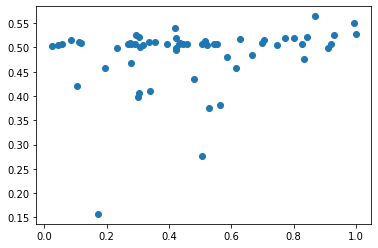

In [ ]:
plt.scatter(output_validation[:, 0], y_pred[:, 0])

In [ ]:
with open("/content/drive/MyDrive/TCN_400/{}.pickle".format(41), "rb") as fin:
    best_tcn = pickle.load(fin)
    model = best_tcn
tcn_400_y_pred = model.predict(input_test)
tcn400_test_nrmse = np.sqrt(np.sum((output_test - tcn_400_y_pred)**2))/np.sqrt(np.sum((output_test - np.average(output_test))**2))
mse = mean_squared_error(output_test, tcn_400_y_pred)
print("test_nrmse is: ",tcn400_test_nrmse)
print("test_mse is:", mse)

2/2 [==============================] - 0s 16ms/step
test_nrmse is:  0.9729840519127527
test_mse is: 0.060578331553446725


In [ ]:
with open("/content/drive/MyDrive/transformer_pk/{}.pickle".format(1), "rb") as fin:
    best_transf = pickle.load(fin)
model_transf = best_transf
y_pred = model_transf.predict(input_test)
test_nrmse = np.sqrt(np.sum((output_test - y_pred)**2))/np.sqrt(np.sum((output_test - np.average(output_test))**2))
mse = mean_squared_error(output_test, y_pred)
print("test_nrmse is: ",test_nrmse)
print("test_mse is:", mse)

2/2 [==============================] - 2s 883ms/step
test_nrmse is:  0.8421295850719867
test_mse is: 0.04537991875378236


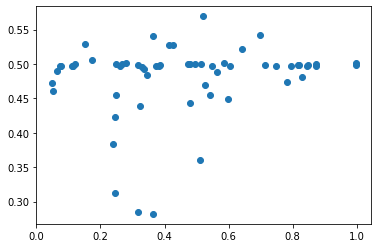

In [ ]:
plt.scatter(output_test[:, 0], tcn_400_y_pred[:, 0])

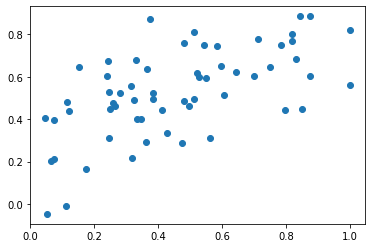

In [ ]:
plt.scatter(output_test[:, 0], y_pred[:, 0])